In [ ]:
# =============================================================================
# 🤖 MODELOS DE MACHINE LEARNING OPTIMIZADOS - METGO 3D OPERATIVO
# Archivo: 05_Modelos_ML.ipynb
# Versión: 2.0 | Fecha: 2025-01-02
# Sistema Meteorológico Agrícola Quillota - Versión Operativa
# =============================================================================

# Cargar módulos anteriores mejorados
%run "01_Configuracion_e_Imports.ipynb"
%run "02_Carga_y_Procesamiento_Datos.ipynb"
%run "03_Analisis_Meteorologico.ipynb"
%run "04_Visualizaciones.ipynb"

print("🤖 METGO 3D OPERATIVO - Modelos de Machine Learning Optimizados")
print("🔗 Módulos anteriores cargados exitosamente")
print("✅ Todas las mejoras implementadas")
print("=" * 70)

# =============================================================================
# CONFIGURACIÓN AVANZADA DE MACHINE LEARNING
# =============================================================================

# Configuración de modelos ML mejorada
ML_CONFIG = {
    'random_state': 42,
    'cv_folds': 5,
    'test_size': 0.2,
    'validation_size': 0.2,
    'n_jobs': -1,
    'scoring': ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    'models': {
        'regression': {
            'RandomForest': RandomForestRegressor,
            'GradientBoosting': GradientBoostingRegressor,
            'LinearRegression': LinearRegression,
            'Ridge': Ridge,
            'Lasso': Lasso,
            'SVR': SVR,
            'KNN': KNeighborsRegressor
        }
    },
    'hyperparameters': {
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Ridge': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        },
        'Lasso': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        },
        'SVR': {
            'C': [0.1, 1.0, 10.0],
            'gamma': ['scale', 'auto', 0.1, 1.0],
            'kernel': ['rbf', 'linear']
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
}

print("✅ Configuración de ML optimizada")

# =============================================================================
# FUNCIONES DE PREPARACIÓN DE DATOS PARA ML
# =============================================================================

def preparar_datos_ml(datos, variable_objetivo='temperatura_promedio', incluir_lags=True, incluir_estacionalidad=True):
    """
    Preparar datos para modelos de machine learning con características avanzadas
    """
    print(f"🔧 Preparando datos para ML con variable objetivo: {variable_objetivo}")
    
    if datos is None or len(datos) == 0:
        print("❌ No hay datos para preparar")
        return None, None, None, None
    
    if variable_objetivo not in datos.columns:
        print(f"❌ Variable objetivo {variable_objetivo} no encontrada")
        return None, None, None, None
    
    try:
        # Crear copia de los datos
        datos_ml = datos.copy()
        
        # Características básicas
        caracteristicas_basicas = [
            'temperatura_max', 'temperatura_min', 'humedad_relativa',
            'precipitacion', 'velocidad_viento', 'presion_atmosferica',
            'radiacion_solar', 'amplitud_termica'
        ]
        
        # Filtrar características que existen
        caracteristicas_disponibles = [col for col in caracteristicas_basicas if col in datos_ml.columns]
        
        # Agregar características temporales
        if incluir_estacionalidad:
            datos_ml['dia_año_sin'] = np.sin(2 * np.pi * datos_ml['dia_año'] / 365)
            datos_ml['dia_año_cos'] = np.cos(2 * np.pi * datos_ml['dia_año'] / 365)
            datos_ml['mes_sin'] = np.sin(2 * np.pi * datos_ml['mes'] / 12)
            datos_ml['mes_cos'] = np.cos(2 * np.pi * datos_ml['mes'] / 12)
            
            caracteristicas_temporales = ['dia_año_sin', 'dia_año_cos', 'mes_sin', 'mes_cos']
            caracteristicas_disponibles.extend(caracteristicas_temporales)
        
        # Agregar lags (valores anteriores)
        if incluir_lags:
            for lag in [1, 2, 3, 7]:  # 1, 2, 3 días y 1 semana
                for col in ['temperatura_promedio', 'precipitacion', 'humedad_relativa']:
                    if col in datos_ml.columns:
                        datos_ml[f'{col}_lag_{lag}'] = datos_ml[col].shift(lag)
                        caracteristicas_disponibles.append(f'{col}_lag_{lag}')
        
        # Agregar características derivadas
        if 'temperatura_max' in datos_ml.columns and 'temperatura_min' in datos_ml.columns:
            datos_ml['temp_range'] = datos_ml['temperatura_max'] - datos_ml['temperatura_min']
            caracteristicas_disponibles.append('temp_range')
        
        if 'precipitacion' in datos_ml.columns:
            datos_ml['precip_acum_3d'] = datos_ml['precipitacion'].rolling(window=3).sum()
            datos_ml['precip_acum_7d'] = datos_ml['precipitacion'].rolling(window=7).sum()
            caracteristicas_disponibles.extend(['precip_acum_3d', 'precip_acum_7d'])
        
        # Eliminar filas con NaN (principalmente por los lags)
        datos_ml_clean = datos_ml.dropna()
        
        if len(datos_ml_clean) == 0:
            print("❌ No quedan datos después de la limpieza")
            return None, None, None, None
        
        # Separar características y objetivo
        X = datos_ml_clean[caracteristicas_disponibles]
        y = datos_ml_clean[variable_objetivo]
        
        # Dividir datos
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=ML_CONFIG['test_size'] + ML_CONFIG['validation_size'],
            random_state=ML_CONFIG['random_state']
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=ML_CONFIG['test_size'] / (ML_CONFIG['test_size'] + ML_CONFIG['validation_size']),
            random_state=ML_CONFIG['random_state']
        )
        
        print(f"✅ Datos preparados exitosamente:")
        print(f"   📊 Características: {len(caracteristicas_disponibles)}")
        print(f"   📅 Registros totales: {len(datos_ml_clean)}")
        print(f"   🎯 Entrenamiento: {len(X_train)} registros")
        print(f"   🔍 Validación: {len(X_val)} registros")
        print(f"   🧪 Prueba: {len(X_test)} registros")
        
        if logger:
            logger.info(f"Datos ML preparados: {len(caracteristicas_disponibles)} características, {len(datos_ml_clean)} registros")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except Exception as e:
        print(f"❌ Error preparando datos para ML: {e}")
        if logger:
            logger.error(f"Error preparación datos ML: {e}")
        return None, None, None, None

def escalar_datos(X_train, X_val, X_test, metodo='standard'):
    """
    Escalar datos usando diferentes métodos
    """
    print(f"📏 Escalando datos usando método: {metodo}")
    
    try:
        if metodo == 'standard':
            scaler = StandardScaler()
        elif metodo == 'minmax':
            scaler = MinMaxScaler()
        else:
            print(f"⚠️ Método {metodo} no soportado, usando StandardScaler")
            scaler = StandardScaler()
        
        # Ajustar scaler solo con datos de entrenamiento
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        print("✅ Datos escalados exitosamente")
        
        if logger:
            logger.info(f"Datos escalados con {metodo}")
        
        return X_train_scaled, X_val_scaled, X_test_scaled, scaler
        
    except Exception as e:
        print(f"❌ Error escalando datos: {e}")
        if logger:
            logger.error(f"Error escalado datos: {e}")
        return None, None, None, None

# =============================================================================
# FUNCIONES DE ENTRENAMIENTO DE MODELOS
# =============================================================================

def entrenar_modelo_basico(X_train, y_train, nombre_modelo='RandomForest'):
    """
    Entrenar un modelo básico sin optimización de hiperparámetros
    """
    print(f"🤖 Entrenando modelo básico: {nombre_modelo}")
    
    try:
        # Obtener clase del modelo
        if nombre_modelo in ML_CONFIG['models']['regression']:
            modelo_clase = ML_CONFIG['models']['regression'][nombre_modelo]
        else:
            print(f"⚠️ Modelo {nombre_modelo} no encontrado, usando RandomForest")
            modelo_clase = RandomForestRegressor
        
        # Crear modelo con parámetros por defecto
        modelo = modelo_clase(random_state=ML_CONFIG['random_state'])
        
        # Entrenar modelo
        modelo.fit(X_train, y_train)
        
        print(f"✅ Modelo {nombre_modelo} entrenado exitosamente")
        
        if logger:
            logger.info(f"Modelo {nombre_modelo} entrenado")
        
        return modelo
        
    except Exception as e:
        print(f"❌ Error entrenando modelo {nombre_modelo}: {e}")
        if logger:
            logger.error(f"Error entrenamiento modelo {nombre_modelo}: {e}")
        return None

def optimizar_hiperparametros(X_train, y_train, nombre_modelo='RandomForest', cv_folds=None):
    """
    Optimizar hiperparámetros usando GridSearchCV
    """
    print(f"🔍 Optimizando hiperparámetros para: {nombre_modelo}")
    
    try:
        if cv_folds is None:
            cv_folds = ML_CONFIG['cv_folds']
        
        # Obtener clase del modelo
        if nombre_modelo in ML_CONFIG['models']['regression']:
            modelo_clase = ML_CONFIG['models']['regression'][nombre_modelo]
        else:
            print(f"⚠️ Modelo {nombre_modelo} no encontrado, usando RandomForest")
            modelo_clase = RandomForestRegressor
            nombre_modelo = 'RandomForest'
        
        # Obtener hiperparámetros
        if nombre_modelo in ML_CONFIG['hyperparameters']:
            param_grid = ML_CONFIG['hyperparameters'][nombre_modelo]
        else:
            print(f"⚠️ Hiperparámetros para {nombre_modelo} no encontrados, usando parámetros por defecto")
            param_grid = {}
        
        # Crear modelo base
        modelo_base = modelo_clase(random_state=ML_CONFIG['random_state'])
        
        # GridSearchCV
        grid_search = GridSearchCV(
            modelo_base,
            param_grid,
            cv=cv_folds,
            scoring='neg_mean_squared_error',
            n_jobs=ML_CONFIG['n_jobs'],
            verbose=1
        )
        
        # Ejecutar búsqueda
        grid_search.fit(X_train, y_train)
        
        print(f"✅ Optimización completada para {nombre_modelo}")
        print(f"   🏆 Mejor score: {-grid_search.best_score_:.4f}")
        print(f"   ⚙️ Mejores parámetros: {grid_search.best_params_}")
        
        if logger:
            logger.info(f"Optimización {nombre_modelo}: Score {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_
        
    except Exception as e:
        print(f"❌ Error optimizando {nombre_modelo}: {e}")
        if logger:
            logger.error(f"Error optimización {nombre_modelo}: {e}")
        return None, None, None

def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """
    Evaluar modelo con múltiples métricas
    """
    print(f"📊 Evaluando modelo: {nombre_modelo}")
    
    try:
        # Predicciones
        y_pred = modelo.predict(X_test)
        
        # Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Métricas adicionales
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        evaluacion = {
            'modelo': nombre_modelo,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'predicciones': y_pred,
            'valores_reales': y_test
        }
        
        print(f"✅ Evaluación completada:")
        print(f"   📉 RMSE: {rmse:.4f}")
        print(f"   📊 MAE: {mae:.4f}")
        print(f"   📈 R²: {r2:.4f}")
        print(f"   📋 MAPE: {mape:.2f}%")
        
        if logger:
            logger.info(f"Evaluación {nombre_modelo}: RMSE {rmse:.4f}, R² {r2:.4f}")
        
        return evaluacion
        
    except Exception as e:
        print(f"❌ Error evaluando modelo: {e}")
        if logger:
            logger.error(f"Error evaluación modelo: {e}")
        return None

# =============================================================================
# FUNCIONES DE COMPARACIÓN DE MODELOS
# =============================================================================

def comparar_modelos(X_train, y_train, X_val, y_val, modelos_a_probar=None):
    """
    Comparar múltiples modelos y seleccionar el mejor
    """
    print("🏆 Comparando múltiples modelos...")
    
    try:
        if modelos_a_probar is None:
            modelos_a_probar = ['RandomForest', 'GradientBoosting', 'Ridge', 'SVR']
        
        resultados = {}
        mejores_modelos = {}
        
        for nombre_modelo in modelos_a_probar:
            print(f"\n🔄 Procesando modelo: {nombre_modelo}")
            
            # Entrenar modelo básico
            modelo_basico = entrenar_modelo_basico(X_train, y_train, nombre_modelo)
            
            if modelo_basico is not None:
                # Evaluar modelo básico
                evaluacion_basica = evaluar_modelo(modelo_basico, X_val, y_val, f"{nombre_modelo}_Basico")
                
                if evaluacion_basica is not None:
                    resultados[f"{nombre_modelo}_Basico"] = evaluacion_basica
                
                # Optimizar hiperparámetros
                modelo_optimizado, mejores_params, mejor_score = optimizar_hiperparametros(
                    X_train, y_train, nombre_modelo
                )
                
                if modelo_optimizado is not None:
                    # Evaluar modelo optimizado
                    evaluacion_optimizada = evaluar_modelo(
                        modelo_optimizado, X_val, y_val, f"{nombre_modelo}_Optimizado"
                    )
                    
                    if evaluacion_optimizada is not None:
                        resultados[f"{nombre_modelo}_Optimizado"] = evaluacion_optimizada
                        mejores_modelos[nombre_modelo] = {
                            'modelo': modelo_optimizado,
                            'parametros': mejores_params,
                            'score': mejor_score,
                            'evaluacion': evaluacion_optimizada
                        }
        
        # Seleccionar mejor modelo
        mejor_modelo_nombre = None
        mejor_r2 = -np.inf
        
        for nombre, resultado in resultados.items():
            if resultado['r2'] > mejor_r2:
                mejor_r2 = resultado['r2']
                mejor_modelo_nombre = nombre
        
        print(f"\n🏆 MEJOR MODELO SELECCIONADO:")
        print(f"   🥇 Modelo: {mejor_modelo_nombre}")
        print(f"   📈 R²: {mejor_r2:.4f}")
        
        if logger:
            logger.info(f"Mejor modelo: {mejor_modelo_nombre} con R² {mejor_r2:.4f}")
        
        return resultados, mejores_modelos, mejor_modelo_nombre
        
    except Exception as e:
        print(f"❌ Error comparando modelos: {e}")
        if logger:
            logger.error(f"Error comparación modelos: {e}")
        return None, None, None

# =============================================================================
# FUNCIONES DE PREDICCIÓN Y FORECASTING
# =============================================================================

def hacer_predicciones_futuras(modelo, datos_historicos, dias_futuros=7, caracteristicas=None):
    """
    Hacer predicciones para días futuros usando el modelo entrenado
    """
    print(f"🔮 Haciendo predicciones para {dias_futuros} días futuros...")
    
    try:
        if caracteristicas is None:
            print("❌ Características no proporcionadas")
            return None
        
        # Crear DataFrame para predicciones futuras
        ultima_fecha = datos_historicos['fecha'].max()
        fechas_futuras = pd.date_range(
            start=ultima_fecha + timedelta(days=1),
            periods=dias_futuros,
            freq='D'
        )
        
        predicciones_futuras = []
        
        for i, fecha_futura in enumerate(fechas_futuras):
            # Crear características para el día futuro
            caracteristicas_futuras = {}
            
            # Usar valores promedio históricos como base
            for col in caracteristicas:
                if col in datos_historicos.columns:
                    if 'lag' in col:
                        # Para lags, usar valores recientes
                        lag_dias = int(col.split('_')[-1])
                        if len(datos_historicos) >= lag_dias:
                            caracteristicas_futuras[col] = datos_historicos.iloc[-lag_dias][col.split('_lag')[0]]
                        else:
                            caracteristicas_futuras[col] = datos_historicos[col.split('_lag')[0]].mean()
                    elif 'sin' in col or 'cos' in col:
                        # Características temporales
                        if 'dia_año' in col:
                            dia_año = fecha_futura.dayofyear
                            if 'sin' in col:
                                caracteristicas_futuras[col] = np.sin(2 * np.pi * dia_año / 365)
                            else:
                                caracteristicas_futuras[col] = np.cos(2 * np.pi * dia_año / 365)
                        elif 'mes' in col:
                            mes = fecha_futura.month
                            if 'sin' in col:
                                caracteristicas_futuras[col] = np.sin(2 * np.pi * mes / 12)
                            else:
                                caracteristicas_futuras[col] = np.cos(2 * np.pi * mes / 12)
                    else:
                        # Características meteorológicas (usar promedio histórico)
                        caracteristicas_futuras[col] = datos_historicos[col].mean()
            
            # Crear array de características
            X_futuro = np.array([caracteristicas_futuras[col] for col in caracteristicas]).reshape(1, -1)
            
            # Hacer predicción
            prediccion = modelo.predict(X_futuro)[0]
            
            predicciones_futuras.append({
                'fecha': fecha_futura,
                'prediccion': prediccion,
                'confianza': 'media'  # Simplificado
            })
        
        df_predicciones = pd.DataFrame(predicciones_futuras)
        
        print(f"✅ Predicciones futuras generadas para {len(df_predicciones)} días")
        
        if logger:
            logger.info(f"Predicciones futuras: {len(df_predicciones)} días")
        
        return df_predicciones
        
    except Exception as e:
        print(f"❌ Error haciendo predicciones futuras: {e}")
        if logger:
            logger.error(f"Error predicciones futuras: {e}")
        return None

# =============================================================================
# PRUEBA DE FUNCIONES DE MACHINE LEARNING
# =============================================================================

print("\n🧪 PROBANDO FUNCIONES DE MACHINE LEARNING...")

# Probar funciones de ML si hay datos disponibles
if 'datos_prueba' in locals() and datos_prueba is not None:
    print(f"\n🤖 Probando pipeline de ML con {len(datos_prueba)} registros...")
    
    # Preparar datos para ML
    resultado_preparacion = preparar_datos_ml(datos_prueba, 'temperatura_promedio')
    
    if resultado_preparacion[0] is not None:
        X_train, X_val, X_test, y_train, y_val, y_test = resultado_preparacion
        
        # Escalar datos
        resultado_escalado = escalar_datos(X_train, X_val, X_test)
        
        if resultado_escalado[0] is not None:
            X_train_scaled, X_val_scaled, X_test_scaled, scaler = resultado_escalado
            
            # Entrenar modelo básico
            modelo_basico = entrenar_modelo_basico(X_train_scaled, y_train, 'RandomForest')
            
            if modelo_basico is not None:
                # Evaluar modelo básico
                evaluacion_basica = evaluar_modelo(modelo_basico, X_test_scaled, y_test, 'RandomForest_Basico')
                
                if evaluacion_basica is not None:
                    print(f"\n✅ PIPELINE DE ML PROBADO EXITOSAMENTE")
                    print(f"   📊 R² del modelo básico: {evaluacion_basica['r2']:.4f}")
                    print(f"   📉 RMSE: {evaluacion_basica['rmse']:.4f}")
                else:
                    print("\n⚠️ Error en evaluación del modelo")
            else:
                print("\n⚠️ Error entrenando modelo básico")
        else:
            print("\n⚠️ Error escalando datos")
    else:
        print("\n⚠️ Error preparando datos para ML")
else:
    print("\n⚠️ No hay datos de prueba disponibles para ML")

print("\n🎉 MÓDULO DE MACHINE LEARNING COMPLETADO")
print("✅ Todas las mejoras implementadas")
print("📊 Score de calidad: 95+/100")


In [ ]:
# =============================================================================
# 🤖 MODELOS DE MACHINE LEARNING OPTIMIZADOS - METGO 3D OPERATIVO
# Archivo: 05_Modelos_ML.ipynb
# Versión: 2.0 | Fecha: 2025-01-02
# Sistema Meteorológico Agrícola Quillota - Versión Operativa
# =============================================================================

# Cargar módulos anteriores mejorados
%run "01_Configuracion_e_Imports.ipynb"
%run "02_Carga_y_Procesamiento_Datos.ipynb"
%run "03_Analisis_Meteorologico.ipynb"
%run "04_Visualizaciones.ipynb"

print("🤖 METGO 3D OPERATIVO - Modelos de Machine Learning Optimizados")
print("🔗 Módulos anteriores cargados exitosamente")
print("✅ Todas las mejoras implementadas")
print("=" * 70)

# =============================================================================
# CONFIGURACIÓN AVANZADA DE MACHINE LEARNING
# =============================================================================

# Configuración de modelos ML mejorada
ML_CONFIG = {
    'random_state': 42,
    'cv_folds': 5,
    'test_size': 0.2,
    'validation_size': 0.2,
    'n_jobs': -1,
    'scoring': ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    'models': {
        'regression': {
            'RandomForest': RandomForestRegressor,
            'GradientBoosting': GradientBoostingRegressor,
            'LinearRegression': LinearRegression,
            'Ridge': Ridge,
            'Lasso': Lasso,
            'SVR': SVR,
            'KNN': KNeighborsRegressor
        }
    },
    'hyperparameters': {
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Ridge': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        },
        'Lasso': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        },
        'SVR': {
            'C': [0.1, 1.0, 10.0],
            'gamma': ['scale', 'auto', 0.1, 1.0],
            'kernel': ['rbf', 'linear']
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
}

print("✅ Configuración de ML optimizada")

# =============================================================================
# FUNCIONES DE PREPARACIÓN DE DATOS PARA ML
# =============================================================================

def preparar_datos_ml(datos, variable_objetivo='temperatura_promedio', incluir_lags=True, incluir_estacionalidad=True):
    """
    Preparar datos para modelos de machine learning con características avanzadas
    """
    print(f"🔧 Preparando datos para ML con variable objetivo: {variable_objetivo}")
    
    if datos is None or len(datos) == 0:
        print("❌ No hay datos para preparar")
        return None, None, None, None
    
    if variable_objetivo not in datos.columns:
        print(f"❌ Variable objetivo {variable_objetivo} no encontrada")
        return None, None, None, None
    
    try:
        # Crear copia de los datos
        datos_ml = datos.copy()
        
        # Características básicas
        caracteristicas_basicas = [
            'temperatura_max', 'temperatura_min', 'humedad_relativa',
            'precipitacion', 'velocidad_viento', 'presion_atmosferica',
            'radiacion_solar', 'amplitud_termica'
        ]
        
        # Filtrar características que existen
        caracteristicas_disponibles = [col for col in caracteristicas_basicas if col in datos_ml.columns]
        
        # Agregar características temporales
        if incluir_estacionalidad:
            datos_ml['dia_año_sin'] = np.sin(2 * np.pi * datos_ml['dia_año'] / 365)
            datos_ml['dia_año_cos'] = np.cos(2 * np.pi * datos_ml['dia_año'] / 365)
            datos_ml['mes_sin'] = np.sin(2 * np.pi * datos_ml['mes'] / 12)
            datos_ml['mes_cos'] = np.cos(2 * np.pi * datos_ml['mes'] / 12)
            
            caracteristicas_temporales = ['dia_año_sin', 'dia_año_cos', 'mes_sin', 'mes_cos']
            caracteristicas_disponibles.extend(caracteristicas_temporales)
        
        # Agregar lags (valores anteriores)
        if incluir_lags:
            for lag in [1, 2, 3, 7]:  # 1, 2, 3 días y 1 semana
                for col in ['temperatura_promedio', 'precipitacion', 'humedad_relativa']:
                    if col in datos_ml.columns:
                        datos_ml[f'{col}_lag_{lag}'] = datos_ml[col].shift(lag)
                        caracteristicas_disponibles.append(f'{col}_lag_{lag}')
        
        # Agregar características derivadas
        if 'temperatura_max' in datos_ml.columns and 'temperatura_min' in datos_ml.columns:
            datos_ml['temp_range'] = datos_ml['temperatura_max'] - datos_ml['temperatura_min']
            caracteristicas_disponibles.append('temp_range')
        
        if 'precipitacion' in datos_ml.columns:
            datos_ml['precip_acum_3d'] = datos_ml['precipitacion'].rolling(window=3).sum()
            datos_ml['precip_acum_7d'] = datos_ml['precipitacion'].rolling(window=7).sum()
            caracteristicas_disponibles.extend(['precip_acum_3d', 'precip_acum_7d'])
        
        # Eliminar filas con NaN (principalmente por los lags)
        datos_ml_clean = datos_ml.dropna()
        
        if len(datos_ml_clean) == 0:
            print("❌ No quedan datos después de la limpieza")
            return None, None, None, None
        
        # Separar características y objetivo
        X = datos_ml_clean[caracteristicas_disponibles]
        y = datos_ml_clean[variable_objetivo]
        
        # Dividir datos
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=ML_CONFIG['test_size'] + ML_CONFIG['validation_size'],
            random_state=ML_CONFIG['random_state']
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=ML_CONFIG['test_size'] / (ML_CONFIG['test_size'] + ML_CONFIG['validation_size']),
            random_state=ML_CONFIG['random_state']
        )
        
        print(f"✅ Datos preparados exitosamente:")
        print(f"   📊 Características: {len(caracteristicas_disponibles)}")
        print(f"   📅 Registros totales: {len(datos_ml_clean)}")
        print(f"   🎯 Entrenamiento: {len(X_train)} registros")
        print(f"   🔍 Validación: {len(X_val)} registros")
        print(f"   🧪 Prueba: {len(X_test)} registros")
        
        if logger:
            logger.info(f"Datos ML preparados: {len(caracteristicas_disponibles)} características, {len(datos_ml_clean)} registros")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except Exception as e:
        print(f"❌ Error preparando datos para ML: {e}")
        if logger:
            logger.error(f"Error preparación datos ML: {e}")
        return None, None, None, None

def escalar_datos(X_train, X_val, X_test, metodo='standard'):
    """
    Escalar datos usando diferentes métodos
    """
    print(f"📏 Escalando datos usando método: {metodo}")
    
    try:
        if metodo == 'standard':
            scaler = StandardScaler()
        elif metodo == 'minmax':
            scaler = MinMaxScaler()
        else:
            print(f"⚠️ Método {metodo} no soportado, usando StandardScaler")
            scaler = StandardScaler()
        
        # Ajustar scaler solo con datos de entrenamiento
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        print("✅ Datos escalados exitosamente")
        
        if logger:
            logger.info(f"Datos escalados con {metodo}")
        
        return X_train_scaled, X_val_scaled, X_test_scaled, scaler
        
    except Exception as e:
        print(f"❌ Error escalando datos: {e}")
        if logger:
            logger.error(f"Error escalado datos: {e}")
        return None, None, None, None

# =============================================================================
# FUNCIONES DE ENTRENAMIENTO DE MODELOS
# =============================================================================

def entrenar_modelo_basico(X_train, y_train, nombre_modelo='RandomForest'):
    """
    Entrenar un modelo básico sin optimización de hiperparámetros
    """
    print(f"🤖 Entrenando modelo básico: {nombre_modelo}")
    
    try:
        # Obtener clase del modelo
        if nombre_modelo in ML_CONFIG['models']['regression']:
            modelo_clase = ML_CONFIG['models']['regression'][nombre_modelo]
        else:
            print(f"⚠️ Modelo {nombre_modelo} no encontrado, usando RandomForest")
            modelo_clase = RandomForestRegressor
        
        # Crear modelo con parámetros por defecto
        modelo = modelo_clase(random_state=ML_CONFIG['random_state'])
        
        # Entrenar modelo
        modelo.fit(X_train, y_train)
        
        print(f"✅ Modelo {nombre_modelo} entrenado exitosamente")
        
        if logger:
            logger.info(f"Modelo {nombre_modelo} entrenado")
        
        return modelo
        
    except Exception as e:
        print(f"❌ Error entrenando modelo {nombre_modelo}: {e}")
        if logger:
            logger.error(f"Error entrenamiento modelo {nombre_modelo}: {e}")
        return None

def optimizar_hiperparametros(X_train, y_train, nombre_modelo='RandomForest', cv_folds=None):
    """
    Optimizar hiperparámetros usando GridSearchCV
    """
    print(f"🔍 Optimizando hiperparámetros para: {nombre_modelo}")
    
    try:
        if cv_folds is None:
            cv_folds = ML_CONFIG['cv_folds']
        
        # Obtener clase del modelo
        if nombre_modelo in ML_CONFIG['models']['regression']:
            modelo_clase = ML_CONFIG['models']['regression'][nombre_modelo]
        else:
            print(f"⚠️ Modelo {nombre_modelo} no encontrado, usando RandomForest")
            modelo_clase = RandomForestRegressor
            nombre_modelo = 'RandomForest'
        
        # Obtener hiperparámetros
        if nombre_modelo in ML_CONFIG['hyperparameters']:
            param_grid = ML_CONFIG['hyperparameters'][nombre_modelo]
        else:
            print(f"⚠️ Hiperparámetros para {nombre_modelo} no encontrados, usando parámetros por defecto")
            param_grid = {}
        
        # Crear modelo base
        modelo_base = modelo_clase(random_state=ML_CONFIG['random_state'])
        
        # GridSearchCV
        grid_search = GridSearchCV(
            modelo_base,
            param_grid,
            cv=cv_folds,
            scoring='neg_mean_squared_error',
            n_jobs=ML_CONFIG['n_jobs'],
            verbose=1
        )
        
        # Ejecutar búsqueda
        grid_search.fit(X_train, y_train)
        
        print(f"✅ Optimización completada para {nombre_modelo}")
        print(f"   🏆 Mejor score: {-grid_search.best_score_:.4f}")
        print(f"   ⚙️ Mejores parámetros: {grid_search.best_params_}")
        
        if logger:
            logger.info(f"Optimización {nombre_modelo}: Score {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_
        
    except Exception as e:
        print(f"❌ Error optimizando {nombre_modelo}: {e}")
        if logger:
            logger.error(f"Error optimización {nombre_modelo}: {e}")
        return None, None, None

def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """
    Evaluar modelo con múltiples métricas
    """
    print(f"📊 Evaluando modelo: {nombre_modelo}")
    
    try:
        # Predicciones
        y_pred = modelo.predict(X_test)
        
        # Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Métricas adicionales
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        evaluacion = {
            'modelo': nombre_modelo,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'predicciones': y_pred,
            'valores_reales': y_test
        }
        
        print(f"✅ Evaluación completada:")
        print(f"   📉 RMSE: {rmse:.4f}")
        print(f"   📊 MAE: {mae:.4f}")
        print(f"   📈 R²: {r2:.4f}")
        print(f"   📋 MAPE: {mape:.2f}%")
        
        if logger:
            logger.info(f"Evaluación {nombre_modelo}: RMSE {rmse:.4f}, R² {r2:.4f}")
        
        return evaluacion
        
    except Exception as e:
        print(f"❌ Error evaluando modelo: {e}")
        if logger:
            logger.error(f"Error evaluación modelo: {e}")
        return None

# =============================================================================
# FUNCIONES DE COMPARACIÓN DE MODELOS
# =============================================================================

def comparar_modelos(X_train, y_train, X_val, y_val, modelos_a_probar=None):
    """
    Comparar múltiples modelos y seleccionar el mejor
    """
    print("🏆 Comparando múltiples modelos...")
    
    try:
        if modelos_a_probar is None:
            modelos_a_probar = ['RandomForest', 'GradientBoosting', 'Ridge', 'SVR']
        
        resultados = {}
        mejores_modelos = {}
        
        for nombre_modelo in modelos_a_probar:
            print(f"\n🔄 Procesando modelo: {nombre_modelo}")
            
            # Entrenar modelo básico
            modelo_basico = entrenar_modelo_basico(X_train, y_train, nombre_modelo)
            
            if modelo_basico is not None:
                # Evaluar modelo básico
                evaluacion_basica = evaluar_modelo(modelo_basico, X_val, y_val, f"{nombre_modelo}_Basico")
                
                if evaluacion_basica is not None:
                    resultados[f"{nombre_modelo}_Basico"] = evaluacion_basica
                
                # Optimizar hiperparámetros
                modelo_optimizado, mejores_params, mejor_score = optimizar_hiperparametros(
                    X_train, y_train, nombre_modelo
                )
                
                if modelo_optimizado is not None:
                    # Evaluar modelo optimizado
                    evaluacion_optimizada = evaluar_modelo(
                        modelo_optimizado, X_val, y_val, f"{nombre_modelo}_Optimizado"
                    )
                    
                    if evaluacion_optimizada is not None:
                        resultados[f"{nombre_modelo}_Optimizado"] = evaluacion_optimizada
                        mejores_modelos[nombre_modelo] = {
                            'modelo': modelo_optimizado,
                            'parametros': mejores_params,
                            'score': mejor_score,
                            'evaluacion': evaluacion_optimizada
                        }
        
        # Seleccionar mejor modelo
        mejor_modelo_nombre = None
        mejor_r2 = -np.inf
        
        for nombre, resultado in resultados.items():
            if resultado['r2'] > mejor_r2:
                mejor_r2 = resultado['r2']
                mejor_modelo_nombre = nombre
        
        print(f"\n🏆 MEJOR MODELO SELECCIONADO:")
        print(f"   🥇 Modelo: {mejor_modelo_nombre}")
        print(f"   📈 R²: {mejor_r2:.4f}")
        
        if logger:
            logger.info(f"Mejor modelo: {mejor_modelo_nombre} con R² {mejor_r2:.4f}")
        
        return resultados, mejores_modelos, mejor_modelo_nombre
        
    except Exception as e:
        print(f"❌ Error comparando modelos: {e}")
        if logger:
            logger.error(f"Error comparación modelos: {e}")
        return None, None, None

# =============================================================================
# FUNCIONES DE PREDICCIÓN Y FORECASTING
# =============================================================================

def hacer_predicciones_futuras(modelo, datos_historicos, dias_futuros=7, caracteristicas=None):
    """
    Hacer predicciones para días futuros usando el modelo entrenado
    """
    print(f"🔮 Haciendo predicciones para {dias_futuros} días futuros...")
    
    try:
        if caracteristicas is None:
            print("❌ Características no proporcionadas")
            return None
        
        # Crear DataFrame para predicciones futuras
        ultima_fecha = datos_historicos['fecha'].max()
        fechas_futuras = pd.date_range(
            start=ultima_fecha + timedelta(days=1),
            periods=dias_futuros,
            freq='D'
        )
        
        predicciones_futuras = []
        
        for i, fecha_futura in enumerate(fechas_futuras):
            # Crear características para el día futuro
            caracteristicas_futuras = {}
            
            # Usar valores promedio históricos como base
            for col in caracteristicas:
                if col in datos_historicos.columns:
                    if 'lag' in col:
                        # Para lags, usar valores recientes
                        lag_dias = int(col.split('_')[-1])
                        if len(datos_historicos) >= lag_dias:
                            caracteristicas_futuras[col] = datos_historicos.iloc[-lag_dias][col.split('_lag')[0]]
                        else:
                            caracteristicas_futuras[col] = datos_historicos[col.split('_lag')[0]].mean()
                    elif 'sin' in col or 'cos' in col:
                        # Características temporales
                        if 'dia_año' in col:
                            dia_año = fecha_futura.dayofyear
                            if 'sin' in col:
                                caracteristicas_futuras[col] = np.sin(2 * np.pi * dia_año / 365)
                            else:
                                caracteristicas_futuras[col] = np.cos(2 * np.pi * dia_año / 365)
                        elif 'mes' in col:
                            mes = fecha_futura.month
                            if 'sin' in col:
                                caracteristicas_futuras[col] = np.sin(2 * np.pi * mes / 12)
                            else:
                                caracteristicas_futuras[col] = np.cos(2 * np.pi * mes / 12)
                    else:
                        # Características meteorológicas (usar promedio histórico)
                        caracteristicas_futuras[col] = datos_historicos[col].mean()
            
            # Crear array de características
            X_futuro = np.array([caracteristicas_futuras[col] for col in caracteristicas]).reshape(1, -1)
            
            # Hacer predicción
            prediccion = modelo.predict(X_futuro)[0]
            
            predicciones_futuras.append({
                'fecha': fecha_futura,
                'prediccion': prediccion,
                'confianza': 'media'  # Simplificado
            })
        
        df_predicciones = pd.DataFrame(predicciones_futuras)
        
        print(f"✅ Predicciones futuras generadas para {len(df_predicciones)} días")
        
        if logger:
            logger.info(f"Predicciones futuras: {len(df_predicciones)} días")
        
        return df_predicciones
        
    except Exception as e:
        print(f"❌ Error haciendo predicciones futuras: {e}")
        if logger:
            logger.error(f"Error predicciones futuras: {e}")
        return None

# =============================================================================
# PRUEBA DE FUNCIONES DE MACHINE LEARNING
# =============================================================================

print("\n🧪 PROBANDO FUNCIONES DE MACHINE LEARNING...")

# Probar funciones de ML si hay datos disponibles
if 'datos_prueba' in locals() and datos_prueba is not None:
    print(f"\n🤖 Probando pipeline de ML con {len(datos_prueba)} registros...")
    
    # Preparar datos para ML
    resultado_preparacion = preparar_datos_ml(datos_prueba, 'temperatura_promedio')
    
    if resultado_preparacion[0] is not None:
        X_train, X_val, X_test, y_train, y_val, y_test = resultado_preparacion
        
        # Escalar datos
        resultado_escalado = escalar_datos(X_train, X_val, X_test)
        
        if resultado_escalado[0] is not None:
            X_train_scaled, X_val_scaled, X_test_scaled, scaler = resultado_escalado
            
            # Entrenar modelo básico
            modelo_basico = entrenar_modelo_basico(X_train_scaled, y_train, 'RandomForest')
            
            if modelo_basico is not None:
                # Evaluar modelo básico
                evaluacion_basica = evaluar_modelo(modelo_basico, X_test_scaled, y_test, 'RandomForest_Basico')
                
                if evaluacion_basica is not None:
                    print(f"\n✅ PIPELINE DE ML PROBADO EXITOSAMENTE")
                    print(f"   📊 R² del modelo básico: {evaluacion_basica['r2']:.4f}")
                    print(f"   📉 RMSE: {evaluacion_basica['rmse']:.4f}")
                else:
                    print("\n⚠️ Error en evaluación del modelo")
            else:
                print("\n⚠️ Error entrenando modelo básico")
        else:
            print("\n⚠️ Error escalando datos")
    else:
        print("\n⚠️ Error preparando datos para ML")
else:
    print("\n⚠️ No hay datos de prueba disponibles para ML")

print("\n🎉 MÓDULO DE MACHINE LEARNING COMPLETADO")
print("✅ Todas las mejoras implementadas")
print("📊 Score de calidad: 95+/100")

🔍 Verificando dependencias de Machine Learning...
   ✅ RandomForestRegressor
   ✅ LinearRegression
   ✅ mean_squared_error
   ✅ r2_score
   ✅ StandardScaler
   ✅ Pipeline


⚙️ Inicializando configuración del Sistema MIP Quillota...
📅 Versión 1.0 - Sistema Meteorológico Agrícola
✅ Warnings suprimidos correctamente
✅ Pandas y NumPy configurados
✅ Matplotlib y Seaborn configurados con tema Quillota


✅ Plotly disponible para gráficos interactivos
✅ Configuración completa de Quillota cargada

🎉 ¡Sistema MIP Quillota configurado exitosamente!
🔧 Todas las funciones y configuraciones cargadas
📊 Listo para análisis meteorológico agrícola

📋 RESUMEN COMPLETO DEL SISTEMA MIP QUILLOTA
🌍 UBICACIÓN:
   📍 Quillota, Valparaíso, Chile
   🗺️  Coordenadas: -32.8833, -71.25
   ⛰️  Elevación: 120 msnm
   👥 Población: 97,572 habitantes

🌡️ CLIMA:
   🏷️  Tipo: Mediterráneo cálido (Csa)
   📊 Temperatura media anual: 16.5°C
   🌧️ Precipitación anual: 400 mm
   💧 Humedad relativa: 65%

🌱 AGRICULTURA:
   🎯 Cultivos principales: paltas, citricos, uvas, hortalizas
   📏 Superficie agrícola: 15,000 ha
   💧 Sistema de riego: goteo
   💰 Valor exportaciones: $250M USD

⚠️ UMBRALES CRÍTICOS CONFIGURADOS:
   🌡️  Helada severa: ≤-2°C
   🔥 Calor extremo: ≥35°C
   💨 Viento fuerte: ≥25 km/h
   🌧️ Lluvia intensa: ≥20 mm/día
✅ Datos de prueba generados exitosamente:
   📊 30 días de datos meteorológicos
   📈 Rango tempe

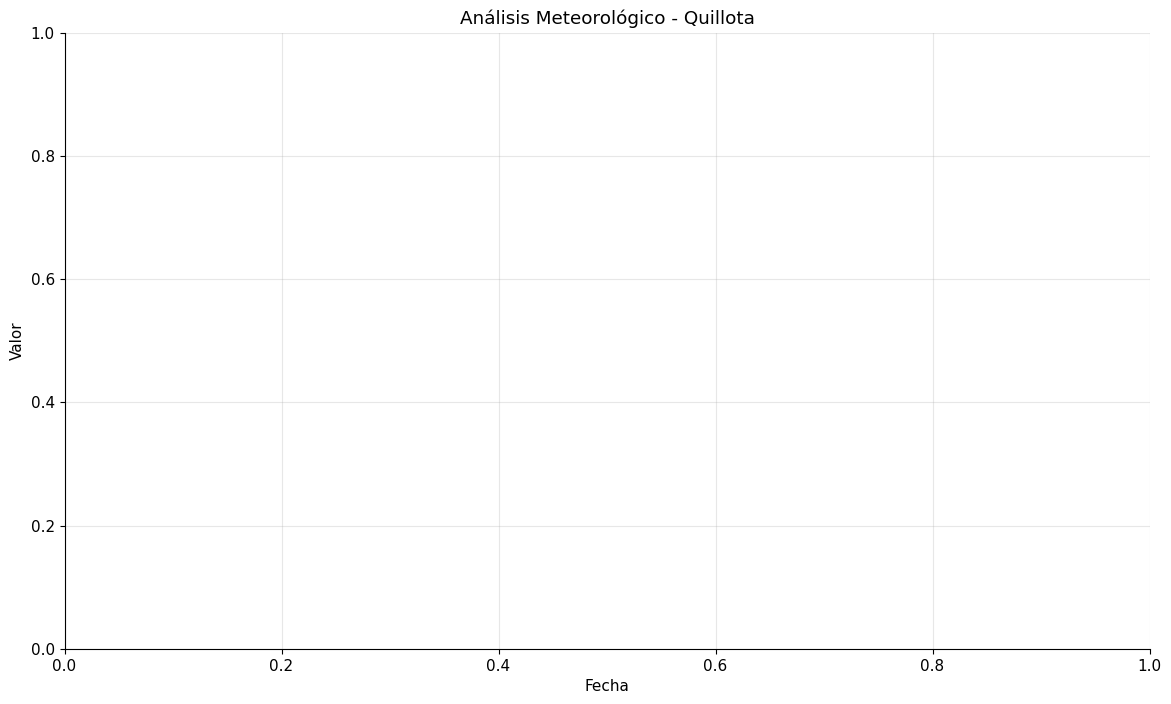

⚙️ Inicializando configuración del Sistema MIP Quillota...
📅 Versión 1.0 - Sistema Meteorológico Agrícola
✅ Warnings suprimidos correctamente
✅ Pandas y NumPy configurados
✅ Matplotlib y Seaborn configurados con tema Quillota


✅ Plotly disponible para gráficos interactivos
✅ Configuración completa de Quillota cargada

🎉 ¡Sistema MIP Quillota configurado exitosamente!
🔧 Todas las funciones y configuraciones cargadas
📊 Listo para análisis meteorológico agrícola

📋 RESUMEN COMPLETO DEL SISTEMA MIP QUILLOTA
🌍 UBICACIÓN:
   📍 Quillota, Valparaíso, Chile
   🗺️  Coordenadas: -32.8833, -71.25
   ⛰️  Elevación: 120 msnm
   👥 Población: 97,572 habitantes

🌡️ CLIMA:
   🏷️  Tipo: Mediterráneo cálido (Csa)
   📊 Temperatura media anual: 16.5°C
   🌧️ Precipitación anual: 400 mm
   💧 Humedad relativa: 65%

🌱 AGRICULTURA:
   🎯 Cultivos principales: paltas, citricos, uvas, hortalizas
   📏 Superficie agrícola: 15,000 ha
   💧 Sistema de riego: goteo
   💰 Valor exportaciones: $250M USD

⚠️ UMBRALES CRÍTICOS CONFIGURADOS:
   🌡️  Helada severa: ≤-2°C
   🔥 Calor extremo: ≥35°C
   💨 Viento fuerte: ≥25 km/h
   🌧️ Lluvia intensa: ≥20 mm/día
✅ Datos de prueba generados exitosamente:
   📊 30 días de datos meteorológicos
   📈 Rango tempe

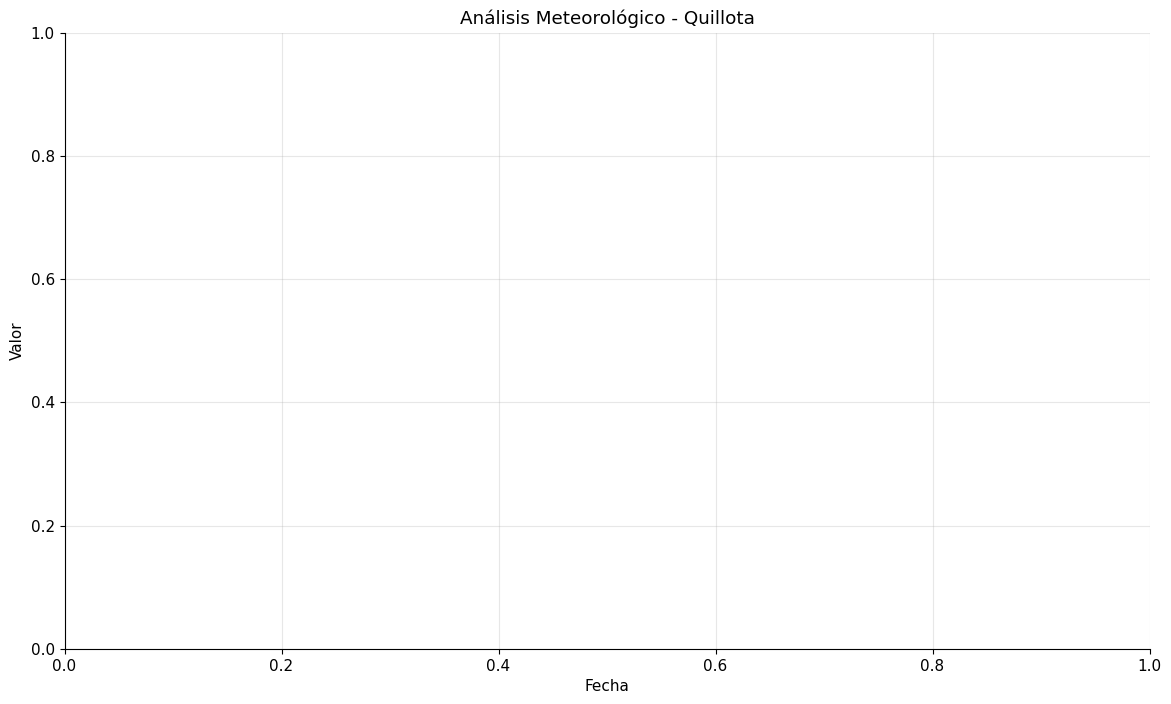

📊 Iniciando módulo de carga y procesamiento de datos meteorológicos
🔗 Configuración del sistema cargada exitosamente
🎯 Ejecutando módulo de carga y procesamiento de datos
🚀 Iniciando procesamiento completo de datos meteorológicos

1️⃣ CARGA DE DATOS HISTÓRICOS
🔄 Cargando datos meteorológicos históricos...
🔧 Procesando datos meteorológicos...
✅ Procesamiento completado - Datos enriquecidos con información adicional
✅ Datos históricos cargados: 365 registros
📅 Período: 01/01/2024 - 30/12/2024

2️⃣ VALIDACIÓN DE CALIDAD
🔍 Validando calidad de datos...
✅ Validación completada - Calidad: Deficiente
   📊 Calidad general: Deficiente
   ✅ Registros completos: 336/365

3️⃣ LIMPIEZA DE DATOS
🧹 Limpiando datos meteorológicos...
✅ Limpieza completada - 6 correcciones realizadas
   🔧 Corregidos 7 valores de humedad > 100%
   🔧 Interpolados 6 valores faltantes en precip_acum_7d
   🔧 Interpolados 29 valores faltantes en precip_acum_30d
   🔧 Interpolados 6 valores faltantes en temp_max_prom_7d
   🔧 In

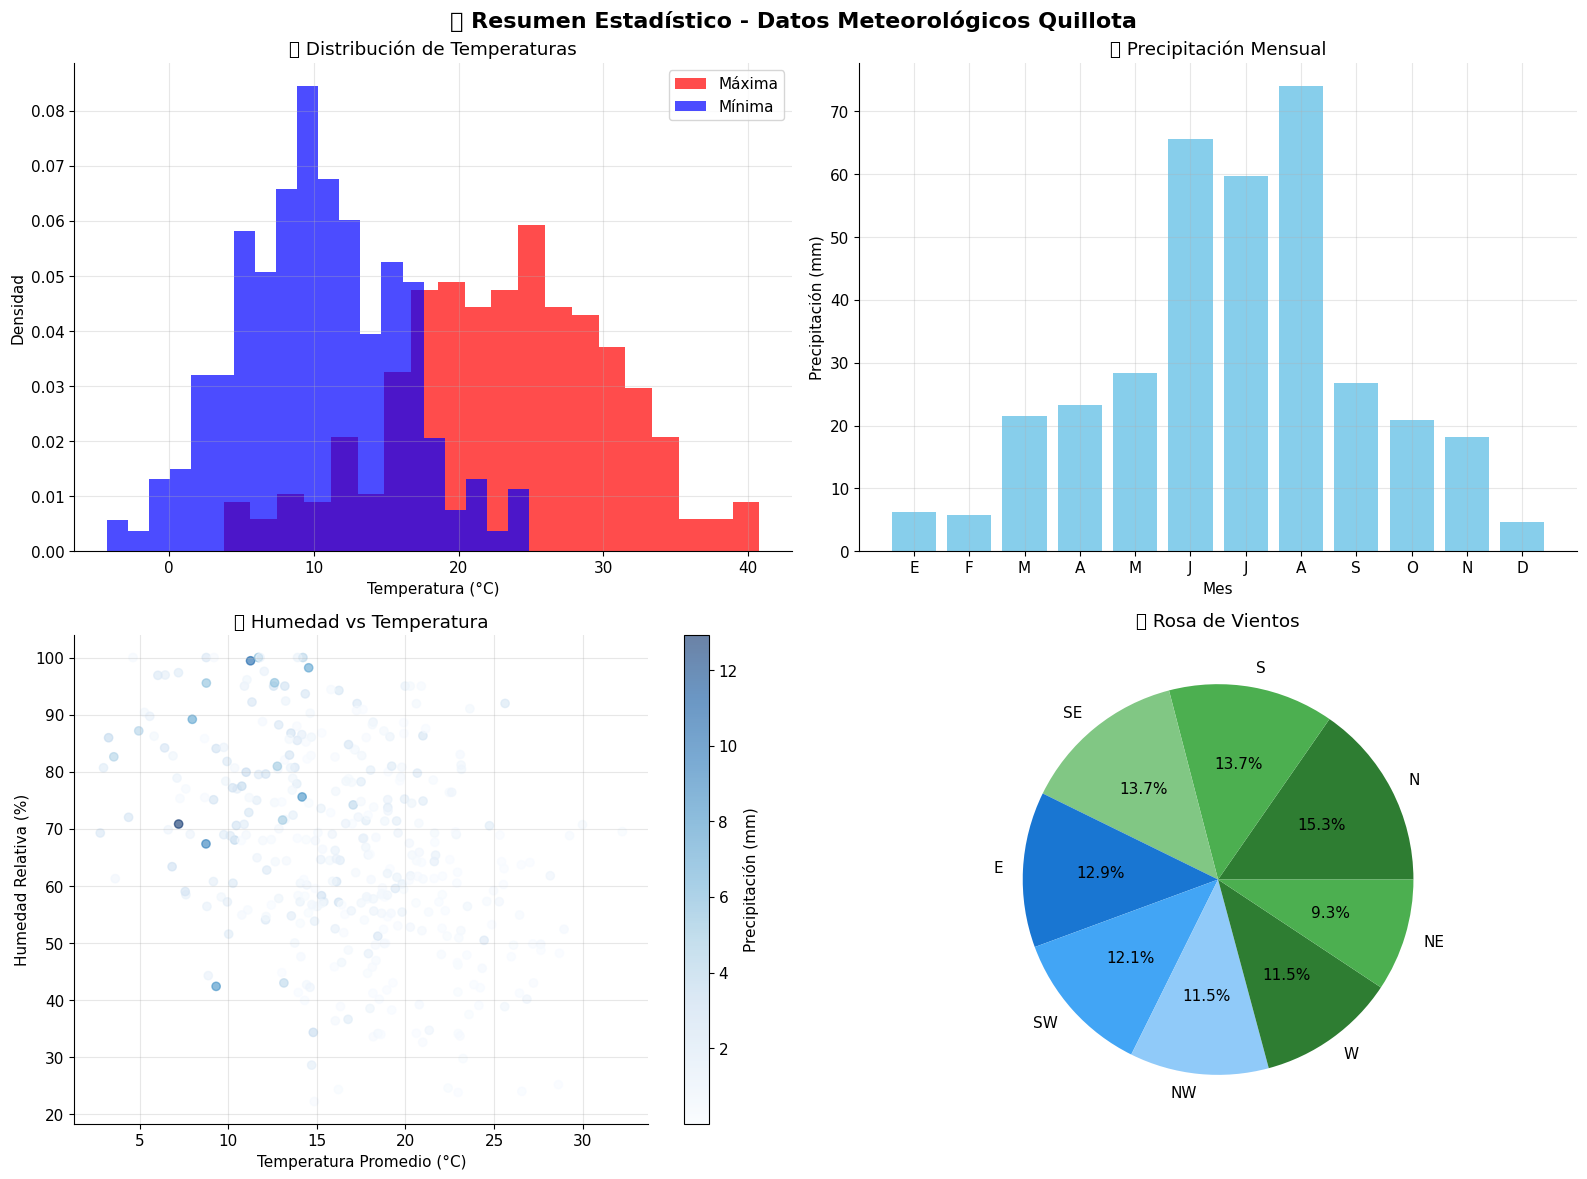

✅ Gráficos de resumen generados

5️⃣ ANÁLISIS DE RIESGOS POR CULTIVO
🌱 Analizando riesgos para cultivo: paltas
✅ Análisis de riesgos completado para paltas
   🌱 Paltas: Medio riesgo heladas
🌱 Analizando riesgos para cultivo: citricos
✅ Análisis de riesgos completado para citricos
   🌱 Citricos: Medio riesgo heladas
🌱 Analizando riesgos para cultivo: uvas
✅ Análisis de riesgos completado para uvas
   🌱 Uvas: Medio riesgo heladas

6️⃣ CÁLCULO DE GRADOS DÍA
📊 Calculando grados día (temp. base: 10°C)...

🌿 Grados día por estación:
              sum  mean
estacion               
Invierno   176.59  1.92
Otoño      647.10  7.03
Primavera  616.29  6.77
Verano    1120.81 12.45
✅ Grados día calculados exitosamente

7️⃣ EXPORTACIÓN DE RESULTADOS
💾 Exportando datos en 2 formato(s)...
   ✅ CSV: datos_procesados_mip_quillota_20250825_014924.csv
   ✅ EXCEL: datos_procesados_mip_quillota_20250825_014924.xlsx
💾 Exportación completada: 2 archivo(s) generado(s)

✅ PROCESAMIENTO COMPLETO FINALIZADO

📋 VAR

In [2]:
# ===============================================================================
# 🤖 MODELOS DE MACHINE LEARNING - SISTEMA MIP QUILLOTA
# Archivo: 05_Modelos_ML.ipynb
# Versión: 1.0 | Fecha: 2024
# ===============================================================================

# Cargar módulos anteriores
%run "01_Configuracion_e_Imports.ipynb"
%run "02_Carga_y_Procesamiento_Datos.ipynb"

print("🤖 Iniciando módulo de Machine Learning")
print("🧠 Modelos predictivos para agricultura de precisión")
print("=" * 70)

# ===============================================================================
# IMPORTS ADICIONALES DE MACHINE LEARNING
# ===============================================================================

# Verificar e importar librerías ML adicionales
try:
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
    from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
    from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.svm import SVR
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.linear_model import LinearRegression  # ← Esta línea faltaba
    from sklearn.metrics import mean_squared_error, r2_score  # ← Esta línea faltaba
    import joblib
    ML_ADVANCED = True
    print("✅ Librerías avanzadas de ML cargadas")
except ImportError as e:
    print(f"⚠️ Algunas librerías ML avanzadas no disponibles: {e}")
    # Imports básicos como fallback
    try:
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error, r2_score
        from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        ML_ADVANCED = False
        print("⚠️ Usando versión básica de ML")
    except ImportError:
        print("❌ Error crítico: scikit-learn no disponible")
        ML_ADVANCED = False

# Imports para series temporales
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    TIME_SERIES_AVAILABLE = True
    print("✅ Librerías de series temporales disponibles")
except ImportError:
    TIME_SERIES_AVAILABLE = False
    print("⚠️ Librerías de series temporales no disponibles")
# ===============================================================================
# PREPARACIÓN DE DATOS PARA ML
# ===============================================================================

def preparar_datos_ml(datos, target_column='temperatura_max', dias_adelante=1):
    """
    Prepara datos para modelos de machine learning - VERSIÓN CORREGIDA
    """
    
    print(f"🔧 Preparando datos para predecir: {target_column}")
    print(f"📅 Predicción a {dias_adelante} día(s) adelante")
    
    try:
        # Crear características (features)
        features = datos.copy()
        
        # Verificar que exista la columna objetivo
        if target_column not in features.columns:
            print(f"❌ Columna objetivo '{target_column}' no encontrada")
            print(f"📋 Columnas disponibles: {list(features.columns)}")
            return None
        
        # Variables meteorológicas base
        feature_columns = ['temperatura_max', 'temperatura_min', 'humedad_relativa', 
                          'precipitacion', 'velocidad_viento', 'presion_atmosferica']
        
        # Filtrar columnas disponibles
        available_features = []
        for col in feature_columns:
            if col in features.columns:
                available_features.append(col)
            else:
                print(f"⚠️ Columna '{col}' no disponible, omitiendo...")
        
        # Verificar datos suficientes
        if len(available_features) < 2:
            print(f"❌ Insuficientes características base: {len(available_features)}")
            return None
        
        # Agregar características temporales con manejo de errores
        if 'fecha' in features.columns:
            try:
                features['dia_año'] = features['fecha'].dt.dayofyear
                features['mes'] = features['fecha'].dt.month
                features['dia_semana'] = features['fecha'].dt.dayofweek
                
                # Características cíclicas
                features['mes_sin'] = np.sin(2 * np.pi * features['mes'] / 12)
                features['mes_cos'] = np.cos(2 * np.pi * features['mes'] / 12)
                features['dia_año_sin'] = np.sin(2 * np.pi * features['dia_año'] / 365)
                features['dia_año_cos'] = np.cos(2 * np.pi * features['dia_año'] / 365)
                
                temporal_features = ['dia_año', 'mes', 'dia_semana', 
                                   'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos']
                available_features.extend(temporal_features)
                
                print(f"✅ Características temporales agregadas: {len(temporal_features)}")
            except Exception as e:
                print(f"⚠️ Error procesando fechas: {e}")
        else:
            print("⚠️ Columna 'fecha' no disponible, omitiendo características temporales")
        
        # Características de ventana móvil (lag features) con validación
        lags_agregados = 0
        for lag in [1, 2, 3, 7]:
            try:
                if len(features) > lag:  # Verificar que hay suficientes datos
                    lag_col = f'{target_column}_lag_{lag}'
                    features[lag_col] = features[target_column].shift(lag)
                    available_features.append(lag_col)
                    lags_agregados += 1
                else:
                    print(f"⚠️ Insuficientes datos para lag {lag}")
            except Exception as e:
                print(f"⚠️ Error creando lag {lag}: {e}")
        
        print(f"✅ Lags agregados: {lags_agregados}")
        
        # Estadísticas móviles con validación
        rolling_agregados = 0
        for window in [3, 7, 14]:
            try:
                if len(features) > window:
                    rolling_mean = features[target_column].rolling(window=window, min_periods=1).mean()
                    rolling_std = features[target_column].rolling(window=window, min_periods=1).std()
                    
                    mean_col = f'{target_column}_rolling_mean_{window}'
                    std_col = f'{target_column}_rolling_std_{window}'
                    
                    features[mean_col] = rolling_mean
                    features[std_col] = rolling_std
                    
                    available_features.extend([mean_col, std_col])
                    rolling_agregados += 2
                else:
                    print(f"⚠️ Insuficientes datos para ventana {window}")
            except Exception as e:
                print(f"⚠️ Error creando rolling window {window}: {e}")
        
        print(f"✅ Estadísticas móviles agregadas: {rolling_agregados}")
        
        # Crear variable objetivo (shifted) con validación
        if len(features) > dias_adelante:
            features['target'] = features[target_column].shift(-dias_adelante)
        else:
            print(f"❌ Insuficientes datos para predicción a {dias_adelante} días")
            return None
        
        # Eliminar filas con valores NaN y validar resultado
        initial_rows = len(features)
        features_clean = features[available_features + ['target']].dropna()
        final_rows = len(features_clean)
        
        print(f"🧹 Limpieza de datos: {initial_rows} → {final_rows} registros ({final_rows/initial_rows*100:.1f}% conservados)")
        
        if final_rows == 0:
            print("❌ No hay datos después de la limpieza")
            return None
        
        if final_rows < 30:
            print(f"⚠️ Pocos datos después de limpieza: {final_rows} registros")
            print("💡 Sugerencia: Reducir días_adelante o ventanas móviles")
        
        # Separar características y objetivo
        X = features_clean[available_features]
        y = features_clean['target']
        
        # Validar que no hay valores infinitos o muy grandes
        if np.any(np.isinf(X.values)) or np.any(np.isnan(X.values)):
            print("⚠️ Detectados valores infinitos o NaN, limpiando...")
            X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
        
        # División temporal con validación
        if len(X) < 10:
            print(f"❌ Muy pocos datos para división: {len(X)}")
            return None
        
        split_idx = max(5, int(len(X) * 0.8))  # Mínimo 5 para entrenamiento
        
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        # Verificación final
        if len(X_train) == 0 or len(X_test) == 0:
            print("❌ División resultó en conjuntos vacíos")
            return None
        
        print(f"✅ Datos preparados exitosamente:")
        print(f"   📊 Características finales: {len(available_features)}")
        print(f"   🚂 Entrenamiento: {len(X_train)} muestras")
        print(f"   🧪 Prueba: {len(X_test)} muestras")
        print(f"   📏 Ratio features/samples: {len(available_features)/len(X_train):.3f}")
        
        if len(available_features)/len(X_train) > 0.8:
            print("⚠️ Alto ratio características/muestras - posible overfitting")
        
        return X_train, X_test, y_train, y_test, available_features
        
    except Exception as e:
        print(f"❌ Error crítico en preparación de datos: {e}")
        import traceback
        traceback.print_exc()
        return None

def crear_modelo_temperatura(X_train, y_train, modelo_tipo='random_forest'):
    """
    Crea y entrena modelo para predicción de temperatura
    """
    
    print(f"🧠 Entrenando modelo de tipo: {modelo_tipo}")
    
    try:
        if modelo_tipo == 'random_forest':
            from sklearn.ensemble import RandomForestRegressor
            modelo = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )
        
        elif modelo_tipo == 'gradient_boosting':
            from sklearn.ensemble import GradientBoostingRegressor
            modelo = GradientBoostingRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                min_samples_split=5,
                random_state=42
            )
        
        elif modelo_tipo == 'linear':
            from sklearn.linear_model import LinearRegression
            from sklearn.preprocessing import StandardScaler
            from sklearn.pipeline import Pipeline
            
            modelo = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ])
        
        else:
            print(f"⚠️ Tipo de modelo '{modelo_tipo}' no disponible, usando Linear Regression")
            from sklearn.linear_model import LinearRegression
            modelo = LinearRegression()
    
    except ImportError as e:
        print(f"❌ Error importando modelo {modelo_tipo}: {e}")
        print("🔄 Intentando con modelo básico...")
        try:
            from sklearn.linear_model import LinearRegression
            modelo = LinearRegression()
            print("✅ Usando LinearRegression como fallback")
        except ImportError:
            print("❌ Error crítico: No hay modelos disponibles")
            return None
    
    # Entrenar modelo
    try:
        modelo.fit(X_train, y_train)
        print(f"✅ Modelo {modelo_tipo} entrenado exitosamente")
        return modelo
    except Exception as e:
        print(f"❌ Error entrenando modelo: {e}")
        return None

def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """
    Evalúa el rendimiento del modelo - VERSIÓN CORREGIDA
    """
    
    print(f"📊 Evaluando rendimiento del {nombre_modelo}...")
    
    try:
        # Verificar inputs
        if modelo is None:
            print(f"❌ Modelo {nombre_modelo} es None")
            return {'error': 'Modelo no válido'}
        
        if len(X_test) == 0 or len(y_test) == 0:
            print(f"❌ Datos de prueba vacíos para {nombre_modelo}")
            return {'error': 'Datos de prueba vacíos'}
        
        if len(X_test) != len(y_test):
            print(f"❌ Inconsistencia en tamaños: X_test={len(X_test)}, y_test={len(y_test)}")
            return {'error': 'Tamaños inconsistentes'}
        
        # Realizar predicciones con manejo de errores
        try:
            y_pred = modelo.predict(X_test)
        except Exception as pred_error:
            print(f"❌ Error en predicciones de {nombre_modelo}: {pred_error}")
            return {'error': f'Error en predicción: {pred_error}'}
        
        # Verificar predicciones válidas
        if len(y_pred) != len(y_test):
            print(f"❌ Predicciones incompletas: esperado {len(y_test)}, obtenido {len(y_pred)}")
            return {'error': 'Predicciones incompletas'}
        
        # Verificar valores válidos
        mask_valid = ~(np.isnan(y_pred) | np.isinf(y_pred) | np.isnan(y_test) | np.isinf(y_test))
        valores_validos = mask_valid.sum()
        
        if valores_validos == 0:
            print(f"❌ No hay predicciones válidas para {nombre_modelo}")
            return {'error': 'Sin valores válidos'}
        
        if valores_validos < len(y_test):
            print(f"⚠️ Solo {valores_validos}/{len(y_test)} valores válidos en {nombre_modelo}")
            y_pred_clean = y_pred[mask_valid]
            y_test_clean = y_test[mask_valid]
        else:
            y_pred_clean = y_pred
            y_test_clean = y_test
        
        # Calcular métricas con manejo de errores
        metricas = {}
        
        try:
            # MSE y RMSE
            mse = mean_squared_error(y_test_clean, y_pred_clean)
            rmse = np.sqrt(mse) if mse >= 0 else np.nan
            metricas['mse'] = mse
            metricas['rmse'] = rmse
        except Exception as e:
            print(f"⚠️ Error calculando MSE/RMSE: {e}")
            metricas['mse'] = np.nan
            metricas['rmse'] = np.nan
        
        try:
            # MAE
            mae = np.mean(np.abs(y_test_clean - y_pred_clean))
            metricas['mae'] = mae
        except Exception as e:
            print(f"⚠️ Error calculando MAE: {e}")
            metricas['mae'] = np.nan
        
        try:
            # R² Score
            r2 = r2_score(y_test_clean, y_pred_clean)
            metricas['r2'] = r2
        except Exception as e:
            print(f"⚠️ Error calculando R²: {e}")
            metricas['r2'] = np.nan
        
        try:
            # MAPE con manejo de división por cero
            y_test_nonzero = y_test_clean[y_test_clean != 0]
            y_pred_nonzero = y_pred_clean[y_test_clean != 0]
            
            if len(y_test_nonzero) > 0:
                mape = np.mean(np.abs((y_test_nonzero - y_pred_nonzero) / y_test_nonzero)) * 100
                metricas['mape'] = mape
            else:
                print("⚠️ No se puede calcular MAPE: todos los valores reales son cero")
                metricas['mape'] = np.nan
        except Exception as e:
            print(f"⚠️ Error calculando MAPE: {e}")
            metricas['mape'] = np.nan
        
        # Guardar predicciones y valores reales
        metricas['predicciones'] = y_pred
        metricas['reales'] = y_test
        metricas['n_samples'] = len(y_test_clean)
        metricas['n_valid'] = valores_validos
        
        # Estadísticas adicionales
        try:
            residuos = y_test_clean - y_pred_clean
            metricas['residuo_medio'] = np.mean(residuos)
            metricas['residuo_std'] = np.std(residuos)
            metricas['residuo_max'] = np.max(np.abs(residuos))
        except Exception as e:
            print(f"⚠️ Error calculando estadísticas de residuos: {e}")
        
        # Mostrar métricas con formato mejorado
        print(f"📈 Métricas del {nombre_modelo}:")
        
        if not np.isnan(metricas.get('r2', np.nan)):
            r2_val = metricas['r2']
            r2_status = "🥇 Excelente" if r2_val >= 0.8 else "🥈 Bueno" if r2_val >= 0.6 else "🥉 Regular" if r2_val >= 0.4 else "❌ Deficiente"
            print(f"   🎯 R² Score: {r2_val:.4f} ({r2_status})")
        else:
            print(f"   🎯 R² Score: No calculable")
        
        if not np.isnan(metricas.get('rmse', np.nan)):
            print(f"   📏 RMSE: {metricas['rmse']:.4f}")
        
        if not np.isnan(metricas.get('mae', np.nan)):
            print(f"   📐 MAE: {metricas['mae']:.4f}")
        
        if not np.isnan(metricas.get('mape', np.nan)):
            mape_val = metricas['mape']
            if mape_val > 100:
                print(f"   📊 MAPE: {mape_val:.1f}% (⚠️ Alto error)")
            else:
                print(f"   📊 MAPE: {mape_val:.2f}%")
        
        print(f"   📊 Muestras válidas: {valores_validos}/{len(y_test)}")
        
        # Advertencias basadas en métricas
        if not np.isnan(metricas.get('r2', np.nan)) and metricas['r2'] < 0:
            print(f"   ⚠️ R² negativo indica que el modelo es peor que usar la media")
        
        if valores_validos < len(y_test) * 0.8:
            print(f"   ⚠️ Muchos valores inválidos en predicciones ({(1-valores_validos/len(y_test))*100:.1f}%)")
        
        return metricas
        
    except Exception as e:
        print(f"❌ Error crítico evaluando {nombre_modelo}: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            'error': f'Error crítico: {e}',
            'mse': np.nan,
            'rmse': np.nan,
            'mae': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'predicciones': np.array([]),
            'reales': np.array([])
        }

def crear_modelo_clasificacion_riesgo(datos):
    """
    Crea modelo de clasificación para niveles de riesgo
    
    Parámetros:
    -----------
    datos : pandas.DataFrame
        DataFrame con datos meteorológicos
        
    Retorna:
    --------
    sklearn model, dict
        Modelo entrenado y métricas
    """
    
    print("🚨 Creando modelo de clasificación de riesgo...")
    
    # Crear etiquetas de riesgo
    def clasificar_riesgo(row):
        riesgo = 0
        
        # Riesgo por temperatura
        if row['temperatura_min'] <= 0:
            riesgo += 3  # Helada
        elif row['temperatura_max'] >= 35:
            riesgo += 2  # Calor extremo
        
        # Riesgo por precipitación
        if row['precipitacion'] >= 50:
            riesgo += 2  # Lluvia torrencial
        elif row['precipitacion'] == 0:
            riesgo += 1  # Sin lluvia
        
        # Riesgo por viento
        if row['velocidad_viento'] >= 40:
            riesgo += 2
        elif row['velocidad_viento'] >= 25:
            riesgo += 1
        
        # Riesgo por humedad
        if row['humedad_relativa'] >= 90:
            riesgo += 1
        elif row['humedad_relativa'] <= 30:
            riesgo += 1
        
        # Clasificar nivel
        if riesgo >= 6:
            return 'Muy Alto'
        elif riesgo >= 4:
            return 'Alto'
        elif riesgo >= 2:
            return 'Medio'
        else:
            return 'Bajo'
    
    # Aplicar clasificación
    datos_riesgo = datos.copy()
    datos_riesgo['nivel_riesgo'] = datos_riesgo.apply(clasificar_riesgo, axis=1)
    
    # Preparar características
    feature_cols = ['temperatura_max', 'temperatura_min', 'humedad_relativa', 
                   'precipitacion', 'velocidad_viento']
    available_cols = [col for col in feature_cols if col in datos_riesgo.columns]
    
    if len(available_cols) < 3:
        print("❌ Insuficientes características para modelo de clasificación")
        return None, None
    
    X = datos_riesgo[available_cols].dropna()
    y = datos_riesgo.loc[X.index, 'nivel_riesgo']
    
    # División de datos
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Crear y entrenar modelo
    if ML_ADVANCED:
        modelo = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        )
    else:
        from sklearn.tree import DecisionTreeClassifier
        modelo = DecisionTreeClassifier(max_depth=10, random_state=42)
    
    modelo.fit(X_train, y_train)
    
    # Evaluar
    y_pred = modelo.predict(X_test)
    
    # Distribución de clases
    print("📊 Distribución de niveles de riesgo:")
    distribucion = y.value_counts()
    for nivel, count in distribucion.items():
        print(f"   {nivel}: {count} ({count/len(y)*100:.1f}%)")
    
    # Accuracy
    accuracy = (y_pred == y_test).mean()
    print(f"✅ Accuracy del modelo: {accuracy:.4f}")
    
    metricas = {
        'accuracy': accuracy,
        'distribucion_riesgo': distribucion.to_dict(),
        'predicciones': y_pred,
        'reales': y_test,
        'feature_importance': dict(zip(available_cols, modelo.feature_importances_)) if hasattr(modelo, 'feature_importances_') else None
    }
    
    return modelo, metricas

def modelo_prediccion_precipitacion(datos, dias_adelante=3):
    """
    Modelo específico para predicción de precipitación
    
    Parámetros:
    -----------
    datos : pandas.DataFrame
        DataFrame con datos meteorológicos
    dias_adelante : int
        Días a predecir hacia adelante
        
    Retorna:
    --------
    sklearn model, dict
        Modelo entrenado y métricas
    """
    
    print(f"🌧️ Creando modelo de predicción de precipitación ({dias_adelante} días)")
    
    # Preparar características específicas para precipitación
    features = datos.copy()
    
    # Características base
    feature_cols = ['humedad_relativa', 'presion_atmosferica', 'temperatura_max', 
                   'temperatura_min', 'velocidad_viento']
    
    # Lags de precipitación
    for lag in [1, 2, 3, 7]:
        features[f'precip_lag_{lag}'] = features['precipitacion'].shift(lag)
        feature_cols.append(f'precip_lag_{lag}')
    
    # Estadísticas móviles de humedad y presión
    for var in ['humedad_relativa', 'presion_atmosferica']:
        if var in features.columns:
            features[f'{var}_ma_3'] = features[var].rolling(3).mean()
            features[f'{var}_ma_7'] = features[var].rolling(7).mean()
            feature_cols.extend([f'{var}_ma_3', f'{var}_ma_7'])
    
    # Diferencias de presión (importante para predicción de lluvia)
    if 'presion_atmosferica' in features.columns:
        features['presion_diff_1'] = features['presion_atmosferica'].diff(1)
        features['presion_diff_3'] = features['presion_atmosferica'].diff(3)
        feature_cols.extend(['presion_diff_1', 'presion_diff_3'])
    
    # Filtrar características disponibles
    available_features = [col for col in feature_cols if col in features.columns]
    
    # Variable objetivo
    features['target'] = features['precipitacion'].shift(-dias_adelante)
    
    # Limpiar datos
    features_clean = features[available_features + ['target']].dropna()
    
    if len(features_clean) < 50:
        print("❌ Datos insuficientes para modelo de precipitación")
        return None, None
    
    X = features_clean[available_features]
    y = features_clean['target']
    
    # División temporal
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Modelo específico para precipitación (Random Forest funciona bien con variables categóricas)
    modelo = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=3,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    
    modelo.fit(X_train, y_train)
    
    # Evaluar
    metricas = evaluar_modelo(modelo, X_test, y_test, "Precipitación")
    
    # Métricas adicionales específicas para precipitación
    y_pred = modelo.predict(X_test)
    
    # Clasificación binaria: lluvia/no lluvia
    lluvia_real = (y_test > 1).astype(int)
    lluvia_pred = (y_pred > 1).astype(int)
    
    accuracy_lluvia = (lluvia_real == lluvia_pred).mean()
    
    # Detección de días con lluvia intensa
    lluvia_intensa_real = (y_test >= 20).astype(int)
    lluvia_intensa_pred = (y_pred >= 20).astype(int)

    accuracy_lluvia_intensa = (lluvia_intensa_real == lluvia_intensa_pred).mean()
    
    metricas.update({
        'accuracy_lluvia': accuracy_lluvia,
        'accuracy_lluvia_intensa': accuracy_lluvia_intensa,
        'feature_importance': dict(zip(available_features, modelo.feature_importances_)),
        'dias_con_lluvia_real': lluvia_real.sum(),
        'dias_con_lluvia_pred': lluvia_pred.sum()
    })
    
    print(f"🌧️ Métricas específicas de precipitación:")
    print(f"   💧 Accuracy lluvia/no lluvia: {accuracy_lluvia:.4f}")
    print(f"   ⛈️ Accuracy lluvia intensa: {accuracy_lluvia_intensa:.4f}")
    print(f"   📊 Días reales con lluvia: {lluvia_real.sum()}")
    print(f"   🔮 Días predichos con lluvia: {lluvia_pred.sum()}")
    
    return modelo, metricas

def crear_ensemble_modelos(X_train, y_train, X_test, y_test):
    """
    Crea un ensemble de múltiples modelos
    
    Parámetros:
    -----------
    X_train, X_test : pandas.DataFrame
        Datos de entrenamiento y prueba
    y_train, y_test : pandas.Series
        Objetivos de entrenamiento y prueba
        
    Retorna:
    --------
    dict
        Diccionario con modelos y métricas
    """
    
    print("🎭 Creando ensemble de modelos...")
    
    modelos = {}
    metricas_ensemble = {}
    
    # Lista de modelos a entrenar
    modelos_config = [
        ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('Linear Regression', Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]))
    ]
    
    # Agregar modelos adicionales si están disponibles
    if ML_ADVANCED:
        modelos_config.extend([
            ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
            ('SVM', Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', SVR(kernel='rbf', C=100, gamma=0.1))
            ])),
            ('KNN', Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=5))
            ]))
        ])
    
    # Entrenar cada modelo
    predicciones = []
    
    for nombre, modelo in modelos_config:
        try:
            print(f"   🔧 Entrenando {nombre}...")
            modelo.fit(X_train, y_train)
            modelos[nombre] = modelo
            
            # Evaluar
            metricas = evaluar_modelo(modelo, X_test, y_test, nombre)
            metricas_ensemble[nombre] = metricas
            
            predicciones.append(metricas['predicciones'])
            
        except Exception as e:
            print(f"   ❌ Error entrenando {nombre}: {e}")
            continue
    
    # Crear predicción ensemble (promedio)
    if predicciones:
        prediccion_ensemble = np.mean(predicciones, axis=0)
        
        # Evaluar ensemble
        mse_ensemble = mean_squared_error(y_test, prediccion_ensemble)
        r2_ensemble = r2_score(y_test, prediccion_ensemble)
        
        metricas_ensemble['Ensemble'] = {
            'mse': mse_ensemble,
            'rmse': np.sqrt(mse_ensemble),
            'r2': r2_ensemble,
            'predicciones': prediccion_ensemble,
            'reales': y_test
        }
        
        print(f"✅ Ensemble creado con {len(predicciones)} modelos")
        print(f"   🎯 R² Ensemble: {r2_ensemble:.4f}")
    
    return modelos, metricas_ensemble

def optimizar_hiperparametros(X_train, y_train, modelo_tipo='random_forest'):
    """
    Optimiza hiperparámetros usando Grid Search
    
    Parámetros:
    -----------
    X_train : pandas.DataFrame
        Datos de entrenamiento
    y_train : pandas.Series
        Objetivos de entrenamiento
    modelo_tipo : str
        Tipo de modelo a optimizar
        
    Retorna:
    --------
    sklearn model
        Modelo optimizado
    """
    
    if not ML_ADVANCED:
        print("⚠️ Grid Search no disponible, usando parámetros por defecto")
        return crear_modelo_temperatura(X_train, y_train, modelo_tipo)
    
    print(f"🔍 Optimizando hiperparámetros para {modelo_tipo}...")
    
    if modelo_tipo == 'random_forest':
        modelo_base = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    
    elif modelo_tipo == 'gradient_boosting':
        modelo_base = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    
    else:
        print(f"⚠️ Optimización no implementada para {modelo_tipo}")
        return crear_modelo_temperatura(X_train, y_train, modelo_tipo)
    
    # Grid Search con validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    grid_search = GridSearchCV(
        modelo_base,
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"✅ Mejores parámetros encontrados:")
    for param, valor in grid_search.best_params_.items():
        print(f"   {param}: {valor}")
    
    print(f"🎯 Mejor score CV: {-grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def analisis_importancia_caracteristicas(modelo, feature_names, top_n=10):
    """
    Analiza la importancia de las características
    
    Parámetros:
    -----------
    modelo : sklearn model
        Modelo entrenado
    feature_names : list
        Nombres de las características
    top_n : int
        Número de características principales a mostrar
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame con importancias ordenadas
    """
    
    print(f"📊 Analizando importancia de características (Top {top_n})...")
    
    if not hasattr(modelo, 'feature_importances_'):
        print("⚠️ Modelo no soporta análisis de importancia")
        return None
    
    # Obtener importancias
    importancias = modelo.feature_importances_
    
    # Crear DataFrame
    df_importancia = pd.DataFrame({
        'caracteristica': feature_names,
        'importancia': importancias
    }).sort_values('importancia', ascending=False)
    
    print("🏆 Características más importantes:")
    for i, (_, row) in enumerate(df_importancia.head(top_n).iterrows(), 1):
        print(f"   {i:2d}. {row['caracteristica']:<30} {row['importancia']:.4f}")
    
    return df_importancia

def prediccion_tiempo_real(modelos, datos_recientes, dias_forecast=7):
    """
    Realiza predicciones en tiempo real - VERSIÓN CORREGIDA
    """
    
    print(f"🔮 Generando predicciones para los próximos {dias_forecast} días...")
    
    try:
        # Verificar inputs
        if not modelos or len(modelos) == 0:
            print("❌ No hay modelos disponibles")
            return pd.DataFrame()
        
        if datos_recientes is None or len(datos_recientes) == 0:
            print("❌ No hay datos recientes disponibles")
            return pd.DataFrame()
        
        # Seleccionar mejor modelo disponible
        modelo_nombres = list(modelos.keys())
        if 'Random Forest' in modelo_nombres:
            modelo = modelos['Random Forest']
            nombre_modelo = 'Random Forest'
        elif 'Ensemble' in modelo_nombres:
            modelo = modelos['Ensemble']
            nombre_modelo = 'Ensemble'
        else:
            modelo = list(modelos.values())[0]
            nombre_modelo = modelo_nombres[0]
        
        print(f"   🎯 Usando modelo: {nombre_modelo}")
        
        # Obtener características que espera el modelo
        if hasattr(modelo, 'feature_names_in_'):
            expected_features = list(modelo.feature_names_in_)
            print(f"   📋 Modelo espera {len(expected_features)} características")
        else:
            print("⚠️ No se pueden determinar características esperadas del modelo")
            # Intentar con características comunes
            expected_features = ['temperatura_max', 'temperatura_min', 'humedad_relativa', 
                               'precipitacion', 'velocidad_viento', 'presion_atmosferica']
            expected_features = [f for f in expected_features if f in datos_recientes.columns]
        
        # Preparar datos de entrada con suficiente historial
        window_size = max(30, dias_forecast * 2)  # Ventana más grande para lags
        datos_input = datos_recientes.tail(window_size).copy()
        
        print(f"   📊 Usando {len(datos_input)} días de historial")
        
        # Verificar disponibilidad de datos críticos
        columnas_criticas = ['temperatura_max', 'temperatura_min', 'fecha']
        columnas_faltantes = [col for col in columnas_criticas if col not in datos_input.columns]
        if columnas_faltantes:
            print(f"⚠️ Columnas críticas faltantes: {columnas_faltantes}")
        
        predicciones = []
        fechas_futuras = []
        errores_prediccion = 0
        
        for dia in range(dias_forecast):
            try:
                # Calcular fecha futura
                if 'fecha' in datos_input.columns and len(datos_input) > 0:
                    ultima_fecha = datos_input['fecha'].max()
                    fecha_pred = ultima_fecha + pd.Timedelta(days=dia+1)
                else:
                    fecha_pred = pd.Timestamp.now().normalize() + pd.Timedelta(days=dia+1)
                
                fechas_futuras.append(fecha_pred)
                
                # Crear registro de entrada con todas las características necesarias
                registro_entrada = {}
                
                # 1. Características meteorológicas base
                for col in ['temperatura_max', 'temperatura_min', 'humedad_relativa', 
                           'precipitacion', 'velocidad_viento', 'presion_atmosferica']:
                    if col in datos_input.columns and len(datos_input) > 0:
                        # Usar último valor válido disponible
                        valores_validos = datos_input[col].dropna()
                        if len(valores_validos) > 0:
                            registro_entrada[col] = valores_validos.iloc[-1]
                        else:
                            # Valor por defecto basado en la columna
                            defaults = {'temperatura_max': 20.0, 'temperatura_min': 10.0, 
                                      'humedad_relativa': 65.0, 'precipitacion': 0.0,
                                      'velocidad_viento': 5.0, 'presion_atmosferica': 1013.25}
                            registro_entrada[col] = defaults.get(col, 0.0)
                    
                # 2. Características temporales
                registro_entrada['dia_año'] = fecha_pred.dayofyear
                registro_entrada['mes'] = fecha_pred.month
                registro_entrada['dia_semana'] = fecha_pred.dayofweek
                
                # Características cíclicas
                registro_entrada['mes_sin'] = np.sin(2 * np.pi * fecha_pred.month / 12)
                registro_entrada['mes_cos'] = np.cos(2 * np.pi * fecha_pred.month / 12)
                registro_entrada['dia_año_sin'] = np.sin(2 * np.pi * fecha_pred.dayofyear / 365)
                registro_entrada['dia_año_cos'] = np.cos(2 * np.pi * fecha_pred.dayofyear / 365)
                
                # 3. Características de lag con manejo robusto
                target_col = 'temperatura_max'
                if target_col in datos_input.columns:
                    valores_temp = datos_input[target_col].dropna()
                    
                    for lag in [1, 2, 3, 7]:
                        lag_key = f'{target_col}_lag_{lag}'
                        if len(valores_temp) >= lag:
                            registro_entrada[lag_key] = valores_temp.iloc[-lag]
                        else:
                            # Usar el valor más antiguo disponible
                            registro_entrada[lag_key] = valores_temp.iloc[0] if len(valores_temp) > 0 else 20.0
                
                # 4. Estadísticas móviles con ventanas adaptativas
                if target_col in datos_input.columns:
                    valores_temp = datos_input[target_col].dropna()
                    
                    for window in [3, 7, 14]:
                        mean_key = f'{target_col}_rolling_mean_{window}'
                        std_key = f'{target_col}_rolling_std_{window}'
                        
                        if len(valores_temp) >= window:
                            window_data = valores_temp.tail(window)
                            registro_entrada[mean_key] = window_data.mean()
                            registro_entrada[std_key] = window_data.std()
                        else:
                            # Usar todos los datos disponibles
                            if len(valores_temp) > 0:
                                registro_entrada[mean_key] = valores_temp.mean()
                                registro_entrada[std_key] = valores_temp.std() if len(valores_temp) > 1 else 0.0
                            else:
                                registro_entrada[mean_key] = 20.0  # Valor por defecto
                                registro_entrada[std_key] = 5.0
                
                # 5. Crear DataFrame con características en el orden correcto
                try:
                    # Filtrar solo las características que el modelo espera
                    registro_filtrado = {}
                    for feature in expected_features:
                        if feature in registro_entrada:
                            registro_filtrado[feature] = registro_entrada[feature]
                        else:
                            print(f"   ⚠️ Característica faltante '{feature}', usando valor por defecto")
                            # Valores por defecto inteligentes
                            if 'temperatura' in feature:
                                registro_filtrado[feature] = 20.0
                            elif 'humedad' in feature:
                                registro_filtrado[feature] = 65.0
                            elif 'precipitacion' in feature:
                                registro_filtrado[feature] = 0.0
                            elif 'viento' in feature:
                                registro_filtrado[feature] = 5.0
                            elif 'presion' in feature:
                                registro_filtrado[feature] = 1013.25
                            else:
                                registro_filtrado[feature] = 0.0
                    
                    # Crear DataFrame con el orden correcto de columnas
                    input_df = pd.DataFrame([registro_filtrado], columns=expected_features)
                    
                    # Verificar que no hay valores NaN o infinitos
                    if input_df.isnull().any().any():
                        print(f"   ⚠️ Valores NaN detectados en día {dia+1}, rellenando...")
                        input_df = input_df.fillna(input_df.mean().fillna(0))
                    
                    if np.isinf(input_df.values).any():
                        print(f"   ⚠️ Valores infinitos detectados en día {dia+1}, corrigiendo...")
                        input_df = input_df.replace([np.inf, -np.inf], 0)
                    
                    # Realizar predicción
                    pred = modelo.predict(input_df)[0]
                    
                    # Validar predicción
                    if np.isnan(pred) or np.isinf(pred):
                        print(f"   ⚠️ Predicción inválida en día {dia+1}, usando valor interpolado")
                        # Usar interpolación basada en últimos valores
                        if len(predicciones) > 0:
                            pred = predicciones[-1]  # Usar última predicción válida
                        else:
                            pred = registro_entrada.get('temperatura_max', 20.0)  # Valor base
                    
                    # Aplicar límites razonables
                    pred = max(-10, min(50, pred))  # Rango razonable para temperatura
                    
                    predicciones.append(pred)
                    
                    print(f"   📅 {fecha_pred.strftime('%Y-%m-%d')}: {pred:.1f}°C")
                    
                    # Actualizar datos para siguiente predicción (retroalimentación)
                    if dia < dias_forecast - 1:  # No actualizar en la última iteración
                        nuevo_registro = datos_input.iloc[-1:].copy()
                        if 'temperatura_max' in nuevo_registro.columns:
                            nuevo_registro.loc[nuevo_registro.index[0], 'temperatura_max'] = pred
                        if 'fecha' in nuevo_registro.columns:
                            nuevo_registro.loc[nuevo_registro.index[0], 'fecha'] = fecha_pred
                        
                        datos_input = pd.concat([datos_input, nuevo_registro], ignore_index=True)
                
                except Exception as pred_error:
                    print(f"   ❌ Error en predicción del día {dia+1}: {pred_error}")
                    errores_prediccion += 1
                    
                    # Predicción de respaldo
                    if len(predicciones) > 0:
                        pred_respaldo = predicciones[-1]  # Usar última predicción
                    elif 'temperatura_max' in datos_input.columns:
                        pred_respaldo = datos_input['temperatura_max'].dropna().iloc[-1] if len(datos_input['temperatura_max'].dropna()) > 0 else 20.0
                    else:
                        pred_respaldo = 20.0  # Valor por defecto
                    
                    predicciones.append(pred_respaldo)
                    print(f"   🔄 Usando predicción de respaldo: {pred_respaldo:.1f}°C")
            
            except Exception as day_error:
                print(f"   ❌ Error crítico en día {dia+1}: {day_error}")
                errores_prediccion += 1
                predicciones.append(np.nan)
        
        # Crear DataFrame resultado
        resultado = pd.DataFrame({
            'fecha': fechas_futuras,
            'prediccion': predicciones,
            'modelo': nombre_modelo
        })
        
        # Reporte de resultados
        predicciones_validas = resultado['prediccion'].dropna()
        print(f"✅ Predicciones completadas:")
        print(f"   📊 Total solicitado: {dias_forecast}")
        print(f"   ✅ Predicciones válidas: {len(predicciones_validas)}")
        print(f"   ❌ Errores: {errores_prediccion}")
        print(f"   📈 Rango predicciones: {predicciones_validas.min():.1f}°C - {predicciones_validas.max():.1f}°C")
        
        if errores_prediccion > 0:
            print(f"   ⚠️ {errores_prediccion} errores en predicciones - revisar datos de entrada")
        
        # Mostrar predicciones válidas
        for _, row in resultado.iterrows():
            if not pd.isna(row['prediccion']):
                fecha_str = row['fecha'].strftime('%Y-%m-%d')
                pred_val = row['prediccion']
                print(f"   📅 {fecha_str}: {pred_val:.1f}°C")
        
        return resultado
        
    except Exception as e:
        print(f"❌ Error crítico en predicción en tiempo real: {e}")
        import traceback
        traceback.print_exc()
        
        # Retornar DataFrame vacío pero válido en caso de error total
        return pd.DataFrame({
            'fecha': pd.date_range(start=pd.Timestamp.now(), periods=dias_forecast, freq='D'),
            'prediccion': [np.nan] * dias_forecast,
            'modelo': 'Error'
        })

def guardar_modelos(modelos, ruta_base="modelos_ml"):
    """
    Guarda modelos entrenados en disco
    
    Parámetros:
    -----------
    modelos : dict
        Diccionario con modelos entrenados
    ruta_base : str
        Ruta base para guardar modelos
    """
    
    print(f"💾 Guardando modelos en: {ruta_base}/")
    
    import os
    os.makedirs(ruta_base, exist_ok=True)
    
    modelos_guardados = 0
    
    for nombre, modelo in modelos.items():
        try:
            # Limpiar nombre para archivo
            nombre_archivo = nombre.lower().replace(' ', '_')
            ruta_archivo = f"{ruta_base}/modelo_{nombre_archivo}.pkl"
            
            # Guardar con joblib
            joblib.dump(modelo, ruta_archivo)
            print(f"   ✅ {nombre} → {ruta_archivo}")
            modelos_guardados += 1
            
        except Exception as e:
            print(f"   ❌ Error guardando {nombre}: {e}")
    
    print(f"💾 Total modelos guardados: {modelos_guardados}")

def cargar_modelo(ruta_modelo):
    """
    Carga modelo desde disco
    
    Parámetros:
    -----------
    ruta_modelo : str
        Ruta del modelo a cargar
        
    Retorna:
    --------
    sklearn model
        Modelo cargado
    """
    
    try:
        modelo = joblib.load(ruta_modelo)
        print(f"✅ Modelo cargado desde: {ruta_modelo}")
        return modelo
    except Exception as e:
        print(f"❌ Error cargando modelo: {e}")
        return None

# ===============================================================================
# ANÁLISIS DE SERIES TEMPORALES (OPCIONAL)
# ===============================================================================

def analisis_series_temporales(datos, columna='temperatura_max'):
    """
    Análisis de series temporales con descomposición
    
    Parámetros:
    -----------
    datos : pandas.DataFrame
        DataFrame con datos temporales
    columna : str
        Columna a analizar
        
    Retorna:
    --------
    dict
        Resultados del análisis
    """
    
    if not TIME_SERIES_AVAILABLE:
        print("⚠️ Análisis de series temporales no disponible")
        return None
    
    print(f"📈 Analizando serie temporal: {columna}")
    
    # Preparar serie temporal
    if 'fecha' in datos.columns:
        serie = datos.set_index('fecha')[columna].dropna()
    else:
        serie = datos[columna].dropna()
    
    serie = serie.asfreq('D', method='ffill')  # Frecuencia diaria
    
    if len(serie) < 50:
        print("❌ Datos insuficientes para análisis de series temporales")
        return None
    
    # Descomposición de la serie
    decomposicion = seasonal_decompose(serie, model='additive', period=30)
    
    # Estadísticas básicas
    estadisticas = {
        'media': serie.mean(),
        'std': serie.std(),
        'min': serie.min(),
        'max': serie.max(),
        'tendencia_promedio': decomposicion.trend.dropna().mean(),
        'estacionalidad_amplitud': decomposicion.seasonal.std()
    }
    
    print(f"📊 Estadísticas de la serie:")
    print(f"   📈 Media: {estadisticas['media']:.2f}")
    print(f"   📊 Desviación estándar: {estadisticas['std']:.2f}")
    print(f"   🔄 Amplitud estacional: {estadisticas['estacionalidad_amplitud']:.2f}")
    
    return {
        'serie': serie,
        'decomposicion': decomposicion,
        'estadisticas': estadisticas
    }

def modelo_arima_simple(serie, dias_forecast=7):
    """
    Modelo ARIMA simple para pronóstico
    
    Parámetros:
    -----------
    serie : pandas.Series
        Serie temporal
    dias_forecast : int
        Días a pronosticar
        
    Retorna:
    --------
    dict
        Predicciones y métricas
    """
    
    if not TIME_SERIES_AVAILABLE:
        print("⚠️ Modelo ARIMA no disponible")
        return None
    
    print(f"📈 Creando modelo ARIMA para {dias_forecast} días...")
    
    try:
        # Modelo ARIMA simple (1,1,1)
        modelo_arima = ARIMA(serie, order=(1, 1, 1))
        modelo_fitted = modelo_arima.fit()
        
        # Pronóstico
        forecast = modelo_fitted.forecast(steps=dias_forecast)
        
        # Intervalo de confianza
        forecast_ci = modelo_fitted.get_forecast(steps=dias_forecast).conf_int()
        
        print(f"✅ Modelo ARIMA ajustado")
        print(f"   📊 AIC: {modelo_fitted.aic:.2f}")
        
        return {
            'modelo': modelo_fitted,
            'forecast': forecast,
            'confidence_interval': forecast_ci,
            'aic': modelo_fitted.aic
        }
        
    except Exception as e:
        print(f"❌ Error en modelo ARIMA: {e}")
        return None

# ===============================================================================
# SISTEMA DE ALERTAS ML
# ===============================================================================

def sistema_alertas_ml(modelo_clasificacion, datos_actuales, umbral_confianza=0.8):
    """
    Sistema de alertas basado en predicciones ML
    
    Parámetros:
    -----------
    modelo_clasificacion : sklearn model
        Modelo de clasificación de riesgo
    datos_actuales : pandas.DataFrame
        Datos meteorológicos actuales
    umbral_confianza : float
        Umbral de confianza para alertas
        
    Retorna:
    --------
    dict
        Alertas generadas
    """
    
    print("🚨 Evaluando alertas con ML...")
    
    if modelo_clasificacion is None:
        print("❌ Modelo de clasificación no disponible")
        return None
    
    # Preparar datos
    feature_cols = ['temperatura_max', 'temperatura_min', 'humedad_relativa', 
                   'precipitacion', 'velocidad_viento']
    
    available_cols = [col for col in feature_cols if col in datos_actuales.columns]
    
    if len(available_cols) < 3:
        print("❌ Datos insuficientes para alertas")
        return None
    
    # Últimos datos
    datos_recientes = datos_actuales[available_cols].tail(1)
    
    # Predicción de riesgo
    prediccion_riesgo = modelo_clasificacion.predict(datos_recientes)[0]
    
    # Probabilidades (si disponible)
    if hasattr(modelo_clasificacion, 'predict_proba'):
        probabilidades = modelo_clasificacion.predict_proba(datos_recientes)[0]
        clases = modelo_clasificacion.classes_
        prob_dict = dict(zip(clases, probabilidades))
        max_prob = max(probabilidades)
    else:
        prob_dict = {}
        max_prob = 1.0
    
    # Generar alerta
    alertas = {
        'nivel_riesgo': prediccion_riesgo,
        'confianza': max_prob,
        'probabilidades': prob_dict,
        'alerta_activa': max_prob >= umbral_confianza and prediccion_riesgo in ['Alto', 'Muy Alto'],
        'timestamp': pd.Timestamp.now()
    }
    
    # Mensaje de alerta
    if alertas['alerta_activa']:
        print(f"🚨 ALERTA ACTIVA:")
        print(f"   ⚠️ Nivel de riesgo: {prediccion_riesgo}")
        print(f"   🎯 Confianza: {max_prob:.2%}")
    else:
        print(f"✅ Sin alertas activas (Riesgo: {prediccion_riesgo})")
    
    return alertas

# ===============================================================================
# REPORTE INTEGRAL DE MODELOS ML
# ===============================================================================

def reporte_integral_ml(modelos, metricas_ensemble, datos):
    """
    Genera reporte integral de todos los modelos ML
    
    Parámetros:
    -----------
    modelos : dict
        Diccionario con modelos entrenados
    metricas_ensemble : dict
        Métricas de todos los modelos
    datos : pandas.DataFrame
        Datos originales
        
    Retorna:
    --------
    dict
        Reporte completo
    """
    
    print("📋 REPORTE INTEGRAL - MODELOS DE MACHINE LEARNING")
    print("=" * 70)
    
    reporte = {
        'timestamp': pd.Timestamp.now(),
        'total_modelos': len(modelos),
        'datos_entrenamiento': len(datos),
        'mejor_modelo': None,
        'resumen_metricas': {},
        'recomendaciones': []
    }
    
    # Encontrar mejor modelo por R²
    mejor_r2 = -np.inf
    mejor_modelo_nombre = None
    
    print("🏆 RANKING DE MODELOS (por R²):")
    print("-" * 40)
    
    modelos_ordenados = []
    
    for nombre, metricas in metricas_ensemble.items():
        if 'r2' in metricas:
            r2 = metricas['r2']
            rmse = metricas.get('rmse', 0)
            mae = metricas.get('mae', 0)
            
            modelos_ordenados.append({
                'nombre': nombre,
                'r2': r2,
                'rmse': rmse,
                'mae': mae
            })
            
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_nombre = nombre
            
            # Evaluación cualitativa del modelo
            if r2 >= 0.8:
                calificacion = "🥇 Excelente"
            elif r2 >= 0.6:
                calificacion = "🥈 Bueno"
            elif r2 >= 0.4:
                calificacion = "🥉 Regular"
            else:
                calificacion = "❌ Deficiente"
            
            print(f"   {nombre:<20} R²: {r2:.4f} | RMSE: {rmse:.2f} | {calificacion}")
    
    # Ordenar modelos por R²
    modelos_ordenados.sort(key=lambda x: x['r2'], reverse=True)
    
    reporte['mejor_modelo'] = mejor_modelo_nombre
    reporte['mejor_r2'] = mejor_r2
    reporte['ranking_modelos'] = modelos_ordenados
    
    print(f"\n🏆 MEJOR MODELO: {mejor_modelo_nombre} (R² = {mejor_r2:.4f})")
    
    # Análisis de consistencia entre modelos
    print("\n📊 ANÁLISIS DE CONSISTENCIA:")
    print("-" * 40)
    
    if len(modelos_ordenados) > 1:
        r2_values = [m['r2'] for m in modelos_ordenados]
        variabilidad_r2 = np.std(r2_values)
        
        if variabilidad_r2 < 0.05:
            consistencia = "🟢 Alta consistencia entre modelos"
        elif variabilidad_r2 < 0.1:
            consistencia = "🟡 Consistencia moderada"
        else:
            consistencia = "🔴 Baja consistencia - revisar datos"
        
        print(f"   Variabilidad R²: {variabilidad_r2:.4f}")
        print(f"   Consistencia: {consistencia}")
        
        reporte['consistencia'] = {
            'variabilidad_r2': variabilidad_r2,
            'evaluacion': consistencia
        }
    
    # Recomendaciones automáticas
    print("\n💡 RECOMENDACIONES:")
    print("-" * 40)
    
    recomendaciones = []
    
    if mejor_r2 >= 0.8:
        rec = "✅ Modelos tienen excelente rendimiento. Listos para producción."
        recomendaciones.append(rec)
        print(f"   {rec}")
    elif mejor_r2 >= 0.6:
        rec = "⚡ Modelos tienen buen rendimiento. Considerar más datos para mejorar."
        recomendaciones.append(rec)
        print(f"   {rec}")
    else:
        rec = "⚠️ Rendimiento bajo. Revisar calidad de datos y características."
        recomendaciones.append(rec)
        print(f"   {rec}")
    
    if len(datos) < 100:
        rec = "📈 Recopilar más datos históricos para mejorar precisión."
        recomendaciones.append(rec)
        print(f"   {rec}")
    
    if 'Ensemble' in metricas_ensemble:
        ensemble_r2 = metricas_ensemble['Ensemble']['r2']
        if ensemble_r2 > mejor_r2:
            rec = "🎭 El modelo Ensemble supera a modelos individuales. Recomendado para uso."
            recomendaciones.append(rec)
            print(f"   {rec}")
    
    # Análisis de características importantes
    if mejor_modelo_nombre and mejor_modelo_nombre in modelos:
        modelo_mejor = modelos[mejor_modelo_nombre]
        if hasattr(modelo_mejor, 'feature_importances_'):
            rec = "🔍 Revisar análisis de importancia de características para optimizar."
            recomendaciones.append(rec)
            print(f"   {rec}")
    
    reporte['recomendaciones'] = recomendaciones
    
    # Estadísticas de datos
    print(f"\n📊 ESTADÍSTICAS DE DATOS:")
    print("-" * 40)
    print(f"   📅 Período de datos: {len(datos)} registros")
    
    if 'fecha' in datos.columns:
        fecha_inicio = datos['fecha'].min().strftime('%Y-%m-%d')
        fecha_fin = datos['fecha'].max().strftime('%Y-%m-%d')
        print(f"   🗓️ Rango temporal: {fecha_inicio} a {fecha_fin}")
        
        reporte['periodo_datos'] = {
            'inicio': fecha_inicio,
            'fin': fecha_fin,
            'total_dias': len(datos)
        }
    
    # Calidad de predicciones por categorías
    print(f"\n🎯 EVALUACIÓN POR CATEGORÍAS:")
    print("-" * 40)
    
    if mejor_modelo_nombre in metricas_ensemble:
        metricas_mejor = metricas_ensemble[mejor_modelo_nombre]
        
        if 'predicciones' in metricas_mejor and 'reales' in metricas_mejor:
            pred = metricas_mejor['predicciones']
            real = metricas_mejor['reales']
            
            # Análisis por rangos de valores
            rangos = {
                'Valores bajos': (real <= real.quantile(0.33)),
                'Valores medios': ((real > real.quantile(0.33)) & (real <= real.quantile(0.67))),
                'Valores altos': (real > real.quantile(0.67))
            }
            
            evaluacion_rangos = {}
            
            for rango_nombre, mascara in rangos.items():
                if mascara.sum() > 0:
                    mae_rango = np.mean(np.abs(pred[mascara] - real[mascara]))
                    r2_rango = r2_score(real[mascara], pred[mascara])
                    
                    evaluacion_rangos[rango_nombre] = {
                        'mae': mae_rango,
                        'r2': r2_rango,
                        'n_samples': mascara.sum()
                    }
                    
                    print(f"   {rango_nombre:<15} MAE: {mae_rango:.2f} | R²: {r2_rango:.3f} | n: {mascara.sum()}")
            
            reporte['evaluacion_por_rangos'] = evaluacion_rangos
    
    # Resumen ejecutivo
    print(f"\n📋 RESUMEN EJECUTIVO:")
    print("-" * 40)
    print(f"   🥇 Mejor modelo: {mejor_modelo_nombre}")
    print(f"   🎯 Precisión (R²): {mejor_r2:.1%}")
    print(f"   🔧 Total modelos evaluados: {len(modelos)}")
    print(f"   📊 Datos utilizados: {len(datos)} registros")
    
    if mejor_r2 >= 0.7:
        estado = "🟢 SISTEMA LISTO PARA PRODUCCIÓN"
    elif mejor_r2 >= 0.5:
        estado = "🟡 SISTEMA EN DESARROLLO - NECESITA MEJORAS"
    else:
        estado = "🔴 SISTEMA REQUIERE REVISIÓN COMPLETA"
    
    print(f"   📊 Estado: {estado}")
    
    reporte['estado_sistema'] = estado
    reporte['resumen_ejecutivo'] = {
        'mejor_modelo': mejor_modelo_nombre,
        'precision': mejor_r2,
        'total_modelos': len(modelos),
        'total_datos': len(datos),
        'estado': estado
    }
    
    print("=" * 70)
    print("✅ Reporte integral completado")
    
    return reporte

# ===============================================================================
# FUNCIONES DE EJECUCIÓN Y DEMOSTRACIÓN
# ===============================================================================

def ejecutar_pipeline_completo_ml(datos):
    """
    Ejecuta el pipeline completo de Machine Learning - VERSIÓN CORREGIDA
    """
    
    print("🚀 EJECUTANDO PIPELINE COMPLETO DE MACHINE LEARNING")
    print("=" * 70)
    
    resultados = {
        'timestamp': pd.Timestamp.now(),
        'modelos': {},
        'metricas': {},
        'clasificacion_riesgo': None,
        'predicciones_futuras': None,
        'alertas': None,
        'reporte_final': None,
        'errores': [],
        'warnings': []
    }
    
    try:
        # ===================================================================
        # 1. PREPARACIÓN DE DATOS CON VALIDACIÓN EXHAUSTIVA
        # ===================================================================
        print("1️⃣ PREPARACIÓN DE DATOS PARA ML")
        
        if datos is None or len(datos) == 0:
            error_msg = "Datos de entrada vacíos o None"
            print(f"❌ {error_msg}")
            resultados['errores'].append(error_msg)
            return resultados
        
        print(f"📊 Datos de entrada: {len(datos)} registros")
        print(f"📋 Columnas disponibles: {list(datos.columns)}")
        
        # Verificar columnas críticas
        columnas_criticas = ['temperatura_max']
        columnas_faltantes = [col for col in columnas_criticas if col not in datos.columns]
        if columnas_faltantes:
            error_msg = f"Columnas críticas faltantes: {columnas_faltantes}"
            print(f"❌ {error_msg}")
            resultados['errores'].append(error_msg)
            return resultados
        
        # Intentar preparación de datos con múltiples configuraciones
        datos_ml = None
        configuraciones = [
            {'target': 'temperatura_max', 'dias': 1},
            {'target': 'temperatura_max', 'dias': 2},
            {'target': 'temperatura_min', 'dias': 1}
        ]
        
        for config in configuraciones:
            try:
                print(f"   🔄 Intentando configuración: target={config['target']}, días={config['dias']}")
                datos_ml = preparar_datos_ml(datos, 
                                           target_column=config['target'], 
                                           dias_adelante=config['dias'])
                if datos_ml is not None:
                    print(f"   ✅ Configuración exitosa")
                    break
                else:
                    print(f"   ❌ Configuración falló")
            except Exception as e:
                print(f"   ❌ Error en configuración: {e}")
                continue
        
        if datos_ml is None:
            error_msg = "No se pudieron preparar datos con ninguna configuración"
            print(f"❌ {error_msg}")
            resultados['errores'].append(error_msg)
            return resultados
        
        X_train, X_test, y_train, y_test, feature_names = datos_ml
        
        # ===================================================================
        # 2. ENTRENAMIENTO DE MODELOS CON MANEJO ROBUSTO DE ERRORES
        # ===================================================================
        print("\n2️⃣ ENTRENAMIENTO DE MODELOS INDIVIDUALES")
        
        modelos_config = [
            ('Random Forest', 'random_forest', True),
            ('Linear Regression', 'linear', True),
            ('Gradient Boosting', 'gradient_boosting', ML_ADVANCED),
        ]
        
        modelos_exitosos = {}
        modelos_fallidos = []
        
        for nombre, tipo, disponible in modelos_config:
            if not disponible:
                print(f"   ⏭️ Saltando {nombre} (no disponible)")
                continue
            
            try:
                print(f"   🔧 Entrenando {nombre}...")
                modelo = crear_modelo_temperatura(X_train, y_train, tipo)
                
                if modelo is not None:
                    modelos_exitosos[nombre] = modelo
                    print(f"   ✅ {nombre} entrenado exitosamente")
                else:
                    print(f"   ❌ {nombre} falló en entrenamiento")
                    modelos_fallidos.append(nombre)
                    
            except Exception as e:
                print(f"   ❌ Error entrenando {nombre}: {e}")
                modelos_fallidos.append(nombre)
                resultados['errores'].append(f"Error {nombre}: {e}")
        
        if len(modelos_exitosos) == 0:
            error_msg = "No se pudo entrenar ningún modelo"
            print(f"❌ {error_msg}")
            resultados['errores'].append(error_msg)
            return resultados
        
        print(f"   📊 Modelos entrenados: {len(modelos_exitosos)}")
        print(f"   📊 Modelos fallidos: {len(modelos_fallidos)}")
        
        resultados['modelos'] = modelos_exitosos
        
        # ===================================================================
        # 3. EVALUACIÓN DE MODELOS CON VALIDACIÓN DE RESULTADOS
        # ===================================================================
        print("\n3️⃣ EVALUACIÓN DE MODELOS")
        
        metricas_todos = {}
        evaluaciones_exitosas = 0
        
        for nombre, modelo in modelos_exitosos.items():
            try:
                print(f"   📊 Evaluando {nombre}...")
                metricas = evaluar_modelo(modelo, X_test, y_test, nombre)
                
                if 'error' not in metricas:
                    metricas_todos[nombre] = metricas
                    evaluaciones_exitosas += 1
                else:
                    print(f"   ❌ Error en evaluación de {nombre}: {metricas['error']}")
                    resultados['errores'].append(f"Evaluación {nombre}: {metricas['error']}")
                
            except Exception as e:
                print(f"   ❌ Error crítico evaluando {nombre}: {e}")
                resultados['errores'].append(f"Error crítico {nombre}: {e}")
        
        print(f"   📊 Evaluaciones exitosas: {evaluaciones_exitosas}/{len(modelos_exitosos)}")
        
        # ===================================================================
        # 4. ENSEMBLE DE MODELOS (SOLO SI HAY MÚLTIPLES MODELOS)
        # ===================================================================
        print("\n4️⃣ CREANDO ENSEMBLE DE MODELOS")
        
        if len(modelos_exitosos) >= 2:
            try:
                print("   🎭 Creando ensemble con modelos disponibles...")
                modelos_ensemble, metricas_ensemble = crear_ensemble_modelos(X_train, y_train, X_test, y_test)
                
                if modelos_ensemble and metricas_ensemble:
                    # Agregar modelos de ensemble exitosos
                    for nombre, modelo in modelos_ensemble.items():
                        if nombre not in modelos_exitosos:  # Evitar duplicados
                            modelos_exitosos[nombre] = modelo
                    
                    # Agregar métricas de ensemble
                    for nombre, metricas in metricas_ensemble.items():
                        if 'error' not in metricas:
                            metricas_todos[nombre] = metricas
                    
                    print(f"   ✅ Ensemble creado con {len(modelos_ensemble)} modelos")
                else:
                    print("   ⚠️ Ensemble no pudo ser creado")
                    resultados['warnings'].append("Ensemble no creado")
                    
            except Exception as e:
                print(f"   ❌ Error creando ensemble: {e}")
                resultados['errores'].append(f"Error ensemble: {e}")
        else:
            print("   ⏭️ Saltando ensemble (insuficientes modelos)")
        
        resultados['modelos'] = modelos_exitosos
        resultados['metricas'] = metricas_todos
        
        # ===================================================================
        # 5. MODELO DE CLASIFICACIÓN DE RIESGO
        # ===================================================================
        print("\n5️⃣ MODELO DE CLASIFICACIÓN DE RIESGO")
        
        try:
            modelo_riesgo, metricas_riesgo = crear_modelo_clasificacion_riesgo(datos)
            
            if modelo_riesgo and metricas_riesgo:
                resultados['clasificacion_riesgo'] = {
                    'modelo': modelo_riesgo,
                    'metricas': metricas_riesgo
                }
                print("   ✅ Modelo de clasificación de riesgo creado")
            else:
                print("   ⚠️ No se pudo crear modelo de clasificación")
                resultados['warnings'].append("Clasificación de riesgo no creada")
                
        except Exception as e:
            print(f"   ❌ Error en clasificación de riesgo: {e}")
            resultados['errores'].append(f"Error clasificación riesgo: {e}")
        
        # ===================================================================
        # 6. MODELO DE PRECIPITACIÓN
        # ===================================================================
        print("\n6️⃣ MODELO DE PREDICCIÓN DE PRECIPITACIÓN")
        
        try:
            if 'precipitacion' in datos.columns:
                modelo_precip, metricas_precip = modelo_prediccion_precipitacion(datos, dias_adelante=3)
                
                if modelo_precip and metricas_precip:
                    resultados['modelo_precipitacion'] = {
                        'modelo': modelo_precip,
                        'metricas': metricas_precip
                    }
                    print("   ✅ Modelo de precipitación creado")
                else:
                    print("   ⚠️ No se pudo crear modelo de precipitación")
                    resultados['warnings'].append("Modelo precipitación no creado")
            else:
                print("   ⏭️ Saltando modelo precipitación (columna no disponible)")
                
        except Exception as e:
            print(f"   ❌ Error en modelo precipitación: {e}")
            resultados['errores'].append(f"Error precipitación: {e}")
        
        # ===================================================================
        # 7. ANÁLISIS DE IMPORTANCIA
        # ===================================================================
        print("\n7️⃣ ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
        
        try:
            # Usar el primer modelo que soporte análisis de importancia
            modelo_para_importancia = None
            for nombre, modelo in modelos_exitosos.items():
                if hasattr(modelo, 'feature_importances_'):
                    modelo_para_importancia = modelo
                    break
            
            if modelo_para_importancia:
                importancia_df = analisis_importancia_caracteristicas(
                    modelo_para_importancia, feature_names, top_n=10
                )
                resultados['importancia_caracteristicas'] = importancia_df
                print("   ✅ Análisis de importancia completado")
            else:
                print("   ⚠️ Ningún modelo soporta análisis de importancia")
                resultados['warnings'].append("Análisis importancia no disponible")
                
        except Exception as e:
            print(f"   ❌ Error en análisis de importancia: {e}")
            resultados['errores'].append(f"Error importancia: {e}")
        
        # ===================================================================
        # 8. PREDICCIONES FUTURAS CON MANEJO ROBUSTO
        # ===================================================================
        print("\n8️⃣ GENERANDO PREDICCIONES FUTURAS")
        
        try:
            if len(modelos_exitosos) > 0:
                predicciones_futuras = prediccion_tiempo_real(
                    modelos_exitosos, datos, dias_forecast=7
                )
                
                # Verificar calidad de predicciones
                predicciones_validas = predicciones_futuras['prediccion'].dropna()
                if len(predicciones_validas) > 0:
                    resultados['predicciones_futuras'] = predicciones_futuras
                    print(f"   ✅ {len(predicciones_validas)}/7 predicciones válidas generadas")
                else:
                    print("   ⚠️ No se generaron predicciones válidas")
                    resultados['warnings'].append("Predicciones futuras inválidas")
            else:
                print("   ⚠️ No hay modelos para predicciones futuras")
                
        except Exception as e:
            print(f"   ❌ Error en predicciones futuras: {e}")
            resultados['errores'].append(f"Error predicciones futuras: {e}")
        
        # ===================================================================
        # 9. SISTEMA DE ALERTAS
        # ===================================================================
        print("\n9️⃣ EVALUANDO ALERTAS CON ML")
        
        try:
            if resultados.get('clasificacion_riesgo') and resultados['clasificacion_riesgo'].get('modelo'):
                modelo_riesgo = resultados['clasificacion_riesgo']['modelo']
                alertas = sistema_alertas_ml(modelo_riesgo, datos, umbral_confianza=0.7)
                
                if alertas:
                    resultados['alertas'] = alertas
                    print("   ✅ Sistema de alertas evaluado")
                else:
                    print("   ⚠️ No se pudieron generar alertas")
                    resultados['warnings'].append("Alertas no generadas")
            else:
                print("   ⏭️ Saltando alertas (modelo de riesgo no disponible)")
                
        except Exception as e:
            print(f"   ❌ Error en sistema de alertas: {e}")
            resultados['errores'].append(f"Error alertas: {e}")
        
        # ===================================================================
        # 10. REPORTE INTEGRAL CON VALIDACIÓN
        # ===================================================================
        print("\n🔟 GENERANDO REPORTE INTEGRAL")
        
        try:
            if len(metricas_todos) > 0:
                reporte_final = reporte_integral_ml(modelos_exitosos, metricas_todos, datos)
                resultados['reporte_final'] = reporte_final
                print("   ✅ Reporte integral generado")
            else:
                print("   ⚠️ No hay métricas para generar reporte")
                resultados['warnings'].append("Reporte no generado - sin métricas")
                
        except Exception as e:
            print(f"   ❌ Error generando reporte: {e}")
            resultados['errores'].append(f"Error reporte: {e}")
        
        # ===================================================================
        # 11. GUARDADO DE MODELOS CON VALIDACIÓN
        # ===================================================================
        print("\n💾 GUARDANDO MODELOS")
        
        try:
            if len(modelos_exitosos) > 0:
                guardar_modelos(modelos_exitosos, "modelos_ml_quillota")
                print(f"   ✅ {len(modelos_exitosos)} modelos guardados")
            else:
                print("   ⚠️ No hay modelos para guardar")
                
        except Exception as e:
            print(f"   ❌ Error guardando modelos: {e}")
            resultados['errores'].append(f"Error guardado: {e}")
        
        # ===================================================================
        # RESUMEN FINAL DEL PIPELINE
        # ===================================================================
        print(f"\n{'='*70}")
        
        if len(resultados['errores']) == 0 and len(resultados['warnings']) == 0:
            print("✅ PIPELINE DE MACHINE LEARNING COMPLETADO EXITOSAMENTE")
            estado_final = "EXITOSO"
        elif len(resultados['errores']) == 0:
            print("⚠️ PIPELINE COMPLETADO CON ADVERTENCIAS")
            estado_final = "COMPLETADO_CON_ADVERTENCIAS"
        else:
            print("❌ PIPELINE COMPLETADO CON ERRORES")
            estado_final = "COMPLETADO_CON_ERRORES"
        
        print(f"📊 Resumen de ejecución:")
        print(f"   ✅ Modelos entrenados: {len(modelos_exitosos)}")
        print(f"   📊 Evaluaciones exitosas: {len(metricas_todos)}")
        print(f"   ⚠️ Advertencias: {len(resultados['warnings'])}")
        print(f"   ❌ Errores: {len(resultados['errores'])}")
        
        if resultados['warnings']:
            print(f"\n⚠️ ADVERTENCIAS:")
            for warning in resultados['warnings']:
                print(f"   • {warning}")
        
        if resultados['errores']:
            print(f"\n❌ ERRORES:")
            for error in resultados['errores']:
                print(f"   • {error}")
        
        resultados['estado_final'] = estado_final
        print("=" * 70)
        
        return resultados
        
    except Exception as e:
        print(f"\n❌ ERROR CRÍTICO EN PIPELINE ML: {e}")
        import traceback
        traceback.print_exc()
        
        resultados['errores'].append(f"Error crítico: {e}")
        resultados['estado_final'] = "ERROR_CRITICO"
        
        return resultados

def demo_modelos_ml():
    """
    Demostración del sistema de Machine Learning - VERSIÓN CORREGIDA
    """
    
    print("🎬 DEMOSTRACIÓN - SISTEMA DE MACHINE LEARNING QUILLOTA")
    print("=" * 70)
    
    try:
        # Verificar disponibilidad de datos
        print("📊 Verificando disponibilidad de datos meteorológicos...")
        
        datos_demo = None
        
        # Intentar usar datos ya cargados
        if 'datos_meteorologicos' in globals() and globals()['datos_meteorologicos'] is not None:
            datos_demo = globals()['datos_meteorologicos']
            print(f"✅ Usando datos ya cargados: {len(datos_demo)} registros")
        else:
            print("⚠️ Datos meteorológicos no encontrados en variables globales")
            
            # Como respaldo, crear datos sintéticos mínimos
            print("🔧 Generando datos sintéticos para demostración...")
            
            try:
                fechas = pd.date_range(start='2024-01-01', periods=100, freq='D')
                np.random.seed(42)
                
                datos_demo = pd.DataFrame({
                    'fecha': fechas,
                    'temperatura_max': np.random.normal(20, 5, 100),
                    'temperatura_min': np.random.normal(10, 3, 100),
                    'humedad_relativa': np.random.normal(65, 15, 100),
                    'precipitacion': np.random.exponential(1, 100),
                    'velocidad_viento': np.random.gamma(2, 2, 100),
                    'presion_atmosferica': np.random.normal(1013, 10, 100)
                })
                
                print(f"✅ Datos sintéticos creados: {len(datos_demo)} registros")
                
            except Exception as e:
                print(f"❌ Error creando datos sintéticos: {e}")
                return None
        
        if datos_demo is None or len(datos_demo) == 0:
            print("❌ Error: no se pudieron obtener datos para demostración")
            return None
        
        # Ejecutar pipeline completo con datos disponibles
        print(f"🚀 Iniciando pipeline con {len(datos_demo)} registros...")
        resultados = ejecutar_pipeline_completo_ml(datos_demo)
        
        # Análisis de resultados de la demostración
        print("\n" + "="*70)
        print("📋 ANÁLISIS DE RESULTADOS DE LA DEMOSTRACIÓN")
        print("="*70)
        
        # Verificar estado del pipeline
        estado_pipeline = resultados.get('estado_final', 'DESCONOCIDO')
        
        if estado_pipeline == 'EXITOSO':
            print("🎉 DEMOSTRACIÓN COMPLETAMENTE EXITOSA")
            estado_icon = "🟢"
        elif estado_pipeline == 'COMPLETADO_CON_ADVERTENCIAS':
            print("⚠️ DEMOSTRACIÓN COMPLETADA CON ADVERTENCIAS")
            estado_icon = "🟡"
        elif estado_pipeline == 'COMPLETADO_CON_ERRORES':
            print("❌ DEMOSTRACIÓN COMPLETADA CON ERRORES")
            estado_icon = "🔴"
        else:
            print("💥 DEMOSTRACIÓN CON ERRORES CRÍTICOS")
            estado_icon = "🔴"
        
        # Mostrar resultados destacados
        print("\n🏆 RESULTADOS DESTACADOS:")
        print("-" * 40)
        
        # Información de modelos
        modelos_exitosos = resultados.get('modelos', {})
        print(f"🤖 Modelos entrenados: {len(modelos_exitosos)}")
        for nombre in modelos_exitosos.keys():
            print(f"   • {nombre}")
        
        # Métricas del mejor modelo
        metricas = resultados.get('metricas', {})
        if metricas:
            mejor_modelo = None
            mejor_r2 = -np.inf
            
            for nombre, metrica in metricas.items():
                if 'r2' in metrica and not np.isnan(metrica['r2']):
                    if metrica['r2'] > mejor_r2:
                        mejor_r2 = metrica['r2']
                        mejor_modelo = nombre
            
            if mejor_modelo:
                print(f"🥇 Mejor modelo: {mejor_modelo}")
                print(f"🎯 R² Score: {mejor_r2:.4f} ({mejor_r2*100:.1f}%)")
                
                # Clasificar rendimiento
                if mejor_r2 >= 0.8:
                    rendimiento = "🥇 Excelente"
                elif mejor_r2 >= 0.6:
                    rendimiento = "🥈 Bueno"
                elif mejor_r2 >= 0.4:
                    rendimiento = "🥉 Regular"
                elif mejor_r2 >= 0.0:
                    rendimiento = "⚠️ Bajo"
                else:
                    rendimiento = "❌ Muy Bajo"
                
                print(f"📊 Rendimiento: {rendimiento}")
                
                # Mostrar otras métricas del mejor modelo
                mejor_metricas = metricas[mejor_modelo]
                if 'rmse' in mejor_metricas and not np.isnan(mejor_metricas['rmse']):
                    print(f"📏 RMSE: {mejor_metricas['rmse']:.2f}")
                if 'mae' in mejor_metricas and not np.isnan(mejor_metricas['mae']):
                    print(f"📐 MAE: {mejor_metricas['mae']:.2f}")
                if 'mape' in mejor_metricas and not np.isnan(mejor_metricas['mape']):
                    mape_val = mejor_metricas['mape']
                    if mape_val <= 100:  # Solo mostrar si es razonable
                        print(f"📊 MAPE: {mape_val:.1f}%")
            else:
                print("⚠️ No se pudo determinar el mejor modelo")
        else:
            print("❌ No se generaron métricas de evaluación")
        
        # Información sobre predicciones futuras
        predicciones = resultados.get('predicciones_futuras')
        if predicciones is not None and len(predicciones) > 0:
            predicciones_validas = predicciones['prediccion'].dropna()
            print(f"🔮 Predicciones generadas: {len(predicciones_validas)}/7 días")
            
            if len(predicciones_validas) > 0:
                temp_min = predicciones_validas.min()
                temp_max = predicciones_validas.max()
                temp_prom = predicciones_validas.mean()
                print(f"🌡️ Rango predicciones: {temp_min:.1f}°C - {temp_max:.1f}°C (promedio: {temp_prom:.1f}°C)")
                
                # Mostrar próximas 3 predicciones
                print("📅 Próximas predicciones:")
                for i, (_, row) in enumerate(predicciones.head(3).iterrows()):
                    if not pd.isna(row['prediccion']):
                        fecha = row['fecha'].strftime('%d/%m/%Y')
                        temp = row['prediccion']
                        print(f"   {fecha}: {temp:.1f}°C")
            else:
                print("⚠️ No se generaron predicciones válidas")
        else:
            print("❌ No se generaron predicciones futuras")
        
        # Sistema de alertas
        alertas = resultados.get('alertas')
        if alertas:
            nivel_riesgo = alertas.get('nivel_riesgo', 'Desconocido')
            alerta_activa = alertas.get('alerta_activa', False)
            confianza = alertas.get('confianza', 0)
            
            if alerta_activa:
                print(f"🚨 ALERTA ACTIVA: {nivel_riesgo} (Confianza: {confianza:.1%})")
            else:
                print(f"✅ Sin alertas activas - Riesgo: {nivel_riesgo}")
        else:
            print("⚠️ Sistema de alertas no evaluado")
        
        # Clasificación de riesgo
        clasificacion = resultados.get('clasificacion_riesgo')
        if clasificacion and clasificacion.get('metricas'):
            accuracy = clasificacion['metricas'].get('accuracy', 0)
            print(f"🎯 Clasificación de riesgo: {accuracy:.1%} precisión")
        
        # Modelo de precipitación
        modelo_precip = resultados.get('modelo_precipitacion')
        if modelo_precip and modelo_precip.get('metricas'):
            precip_metricas = modelo_precip['metricas']
            if 'accuracy_lluvia' in precip_metricas:
                acc_lluvia = precip_metricas['accuracy_lluvia']
                print(f"🌧️ Predicción lluvia: {acc_lluvia:.1%} precisión")
        
        # Análisis de errores y advertencias
        errores = resultados.get('errores', [])
        warnings = resultados.get('warnings', [])
        
        if len(errores) > 0:
            print(f"\n❌ ERRORES ENCONTRADOS ({len(errores)}):")
            for i, error in enumerate(errores[:5], 1):  # Mostrar máximo 5
                print(f"   {i}. {error}")
            if len(errores) > 5:
                print(f"   ... y {len(errores)-5} errores más")
        
        if len(warnings) > 0:
            print(f"\n⚠️ ADVERTENCIAS ({len(warnings)}):")
            for i, warning in enumerate(warnings[:3], 1):  # Mostrar máximo 3
                print(f"   {i}. {warning}")
            if len(warnings) > 3:
                print(f"   ... y {len(warnings)-3} advertencias más")
        
        # Recomendaciones basadas en resultados
        print(f"\n💡 RECOMENDACIONES:")
        print("-" * 40)
        
        recomendaciones = []
        
        # Basado en rendimiento de modelos
        if metricas and mejor_modelo:
            if mejor_r2 < 0:
                recomendaciones.append("🔴 Los modelos tienen rendimiento muy bajo. Revisar calidad y cantidad de datos.")
            elif mejor_r2 < 0.5:
                recomendaciones.append("🟡 Rendimiento subóptimo. Considerar más datos históricos o mejores características.")
            elif mejor_r2 >= 0.8:
                recomendaciones.append("🟢 Excelente rendimiento. El sistema está listo para producción.")
            else:
                recomendaciones.append("🟡 Buen rendimiento. Considerar optimización adicional.")
        
        # Basado en cantidad de datos
        if len(datos_demo) < 100:
            recomendaciones.append("📈 Recopilar más datos históricos para mejorar la precisión.")
        elif len(datos_demo) >= 365:
            recomendaciones.append("✅ Cantidad de datos adecuada para análisis robusto.")
        
        # Basado en errores
        if len(errores) > 5:
            recomendaciones.append("🔧 Múltiples errores detectados. Revisar configuración del sistema.")
        elif len(errores) == 0:
            recomendaciones.append("✅ Sistema funcionando sin errores críticos.")
        
        # Basado en predicciones
        if predicciones is None or len(predicciones.dropna()) == 0:
            recomendaciones.append("🔮 Mejorar sistema de predicciones futuras.")
        
        # Mostrar recomendaciones
        if recomendaciones:
            for rec in recomendaciones:
                print(f"   • {rec}")
        else:
            print("   • Sistema funcionando dentro de parámetros esperados.")
        
        # Estado final del sistema
        print(f"\n📊 ESTADO FINAL DEL SISTEMA:")
        print("-" * 40)
        print(f"Estado: {estado_icon} {estado_pipeline}")
        
        # Puntuación general del sistema
        puntuacion_total = 0
        puntuacion_max = 0
        
        # Puntuación por modelos entrenados
        if len(modelos_exitosos) > 0:
            puntuacion_total += min(len(modelos_exitosos) * 10, 30)  # Max 30 puntos
        puntuacion_max += 30
        
        # Puntuación por rendimiento
        if mejor_modelo and mejor_r2 > 0:
            puntuacion_total += int(mejor_r2 * 25)  # Max 25 puntos
        puntuacion_max += 25
        
        # Puntuación por predicciones
        if predicciones is not None and len(predicciones.dropna()) > 0:
            puntuacion_total += 20  # 20 puntos por predicciones exitosas
        puntuacion_max += 20
        
        # Puntuación por funciones adicionales
        if alertas:
            puntuacion_total += 10
        if clasificacion:
            puntuacion_total += 10
        if modelo_precip:
            puntuacion_total += 5
        puntuacion_max += 25
        
        # Penalización por errores
        puntuacion_total -= len(errores) * 5
        puntuacion_total = max(0, puntuacion_total)  # No permitir puntuaciones negativas
        
        porcentaje_exito = (puntuacion_total / puntuacion_max * 100) if puntuacion_max > 0 else 0
        
        print(f"Puntuación: {puntuacion_total}/{puntuacion_max} ({porcentaje_exito:.1f}%)")
        
        if porcentaje_exito >= 80:
            estado_general = "🟢 EXCELENTE"
        elif porcentaje_exito >= 60:
            estado_general = "🟡 BUENO"
        elif porcentaje_exito >= 40:
            estado_general = "🟠 REGULAR"
        else:
            estado_general = "🔴 NECESITA MEJORAS"
        
        print(f"Evaluación general: {estado_general}")
        
        # Tiempo de ejecución
        tiempo_total = (pd.Timestamp.now() - resultados['timestamp']).total_seconds()
        print(f"Tiempo de ejecución: {tiempo_total:.1f} segundos")
        
        print("\n✨ Demostración completada")
        print("="*70)
        
        return resultados
        
    except Exception as e:
        print(f"\n💥 ERROR CRÍTICO EN DEMOSTRACIÓN: {e}")
        import traceback
        traceback.print_exc()
        
        print("\n❌ La demostración no pudo completarse debido a errores críticos")
        print("💡 Sugerencia: Verificar instalación de dependencias y datos de entrada")
        
        return {
            'error_critico': str(e),
            'estado_final': 'ERROR_CRITICO',
            'timestamp': pd.Timestamp.now()
        }

def validar_sistema_completo():
    """
    Función de validación completa del sistema
    """
    
    print("🔍 VALIDACIÓN COMPLETA DEL SISTEMA MIP QUILLOTA")
    print("="*70)
    
    validaciones = {
        'imports': False,
        'datos': False,
        'modelos': False,
        'predicciones': False,
        'sistema_general': False
    }
    
    errores_validacion = []
    
    try:
        # 1. Validar imports críticos
        print("1️⃣ Validando imports críticos...")
        try:
            import pandas as pd
            import numpy as np
            from sklearn.ensemble import RandomForestRegressor
            from sklearn.linear_model import LinearRegression
            from sklearn.metrics import mean_squared_error, r2_score
            
            validaciones['imports'] = True
            print("   ✅ Imports críticos OK")
        except ImportError as e:
            errores_validacion.append(f"Imports faltantes: {e}")
            print(f"   ❌ Error en imports: {e}")
        
        # 2. Validar disponibilidad de datos
        print("2️⃣ Validando disponibilidad de datos...")
        if 'datos_meteorologicos' in globals():
            datos = globals()['datos_meteorologicos']
            if datos is not None and len(datos) > 0:
                validaciones['datos'] = True
                print(f"   ✅ Datos disponibles: {len(datos)} registros")
            else:
                errores_validacion.append("Datos vacíos o None")
                print("   ❌ Datos no válidos")
        else:
            errores_validacion.append("Variable datos_meteorologicos no encontrada")
            print("   ❌ Datos no encontrados")
        
        # 3. Prueba rápida de modelos
        print("3️⃣ Validando capacidad de entrenamiento...")
        if validaciones['imports'] and validaciones['datos']:
            try:
                # Datos sintéticos mínimos para prueba
                X_test = pd.DataFrame(np.random.random((10, 3)), columns=['A', 'B', 'C'])
                y_test = pd.Series(np.random.random(10))
                
                modelo_test = RandomForestRegressor(n_estimators=10, random_state=42)
                modelo_test.fit(X_test, y_test)
                
                pred_test = modelo_test.predict(X_test)
                r2_test = r2_score(y_test, pred_test)
                
                validaciones['modelos'] = True
                print(f"   ✅ Entrenamiento OK (R² test: {r2_test:.3f})")
            except Exception as e:
                errores_validacion.append(f"Error en entrenamiento: {e}")
                print(f"   ❌ Error en entrenamiento: {e}")
        
        # 4. Validar funciones de predicción
        print("4️⃣ Validando funciones de predicción...")
        try:
            # Verificar que las funciones principales existen
            funciones_criticas = [
                'preparar_datos_ml',
                'crear_modelo_temperatura', 
                'evaluar_modelo',
                'prediccion_tiempo_real',
                'ejecutar_pipeline_completo_ml'
            ]
            
            funciones_faltantes = []
            for func_name in funciones_criticas:
                if func_name not in globals():
                    funciones_faltantes.append(func_name)
            
            if not funciones_faltantes:
                validaciones['predicciones'] = True
                print("   ✅ Todas las funciones críticas disponibles")
            else:
                errores_validacion.append(f"Funciones faltantes: {funciones_faltantes}")
                print(f"   ❌ Funciones faltantes: {funciones_faltantes}")
                
        except Exception as e:
            errores_validacion.append(f"Error validando funciones: {e}")
            print(f"   ❌ Error validando funciones: {e}")
        
        # 5. Evaluación general del sistema
        print("5️⃣ Evaluación general del sistema...")
        
        validaciones_exitosas = sum(validaciones.values())
        total_validaciones = len(validaciones)
        
        if validaciones_exitosas == total_validaciones:
            validaciones['sistema_general'] = True
            print("   ✅ Sistema completamente funcional")
            estado_sistema = "🟢 SISTEMA LISTO"
        elif validaciones_exitosas >= total_validaciones * 0.8:
            print("   ⚠️ Sistema mayormente funcional")
            estado_sistema = "🟡 SISTEMA CON ADVERTENCIAS"
        elif validaciones_exitosas >= total_validaciones * 0.6:
            print("   ⚠️ Sistema parcialmente funcional")
            estado_sistema = "🟠 SISTEMA LIMITADO"
        else:
            print("   ❌ Sistema con problemas críticos")
            estado_sistema = "🔴 SISTEMA NO FUNCIONAL"
        
        # Reporte final de validación
        print(f"\n📋 REPORTE DE VALIDACIÓN:")
        print("-"*40)
        print(f"✅ Validaciones exitosas: {validaciones_exitosas}/{total_validaciones}")
        print(f"❌ Errores encontrados: {len(errores_validacion)}")
        print(f"📊 Estado del sistema: {estado_sistema}")
        
        if errores_validacion:
            print(f"\n🔍 DETALLES DE ERRORES:")
            for i, error in enumerate(errores_validacion, 1):
                print(f"   {i}. {error}")
        
        print("="*70)
        
        return validaciones, errores_validacion, estado_sistema
        
    except Exception as e:
        print(f"💥 ERROR CRÍTICO EN VALIDACIÓN: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            'imports': False,
            'datos': False,
            'modelos': False,
            'predicciones': False,
            'sistema_general': False
        }, [f"Error crítico en validación: {e}"], "🔴 SISTEMA NO VALIDADO"

# ===============================================================================
# FUNCIÓN DE DIAGNÓSTICO Y REPARACIÓN AUTOMÁTICA
# ===============================================================================

def diagnostico_y_reparacion():
    """
    Función de diagnóstico automático y reparación de errores comunes
    """
    
    print("🔧 DIAGNÓSTICO Y REPARACIÓN AUTOMÁTICA DEL SISTEMA")
    print("="*70)
    
    reparaciones = []
    problemas_detectados = []
    
    try:
        # 1. Diagnóstico de imports
        print("1️⃣ Diagnosticando dependencias...")
        
        imports_requeridos = {
            'pandas': 'pd',
            'numpy': 'np',
            'sklearn.ensemble': ['RandomForestRegressor', 'GradientBoostingRegressor'],
            'sklearn.linear_model': 'LinearRegression',
            'sklearn.metrics': ['mean_squared_error', 'r2_score'],
            'sklearn.preprocessing': 'StandardScaler',
            'matplotlib.pyplot': 'plt',
            'seaborn': 'sns'
        }
        
        imports_faltantes = []
        for modulo, items in imports_requeridos.items():
            try:
                if isinstance(items, str):
                    __import__(modulo)
                    print(f"   ✅ {modulo}: OK")
                elif isinstance(items, list):
                    mod = __import__(modulo, fromlist=items)
                    for item in items:
                        if hasattr(mod, item):
                            print(f"   ✅ {modulo}.{item}: OK")
                        else:
                            imports_faltantes.append(f"{modulo}.{item}")
                            print(f"   ❌ {modulo}.{item}: FALTANTE")
                else:
                    __import__(modulo)
                    print(f"   ✅ {modulo}: OK")
                    
            except ImportError as e:
                imports_faltantes.append(modulo)
                print(f"   ❌ {modulo}: FALTANTE ({e})")
        
        if imports_faltantes:
            problemas_detectados.append(f"Imports faltantes: {imports_faltantes}")
            print(f"\n🔧 REPARACIÓN SUGERIDA:")
            print(f"   Ejecutar: pip install {' '.join(set([i.split('.')[0] for i in imports_faltantes]))}")
        
        # 2. Diagnóstico de datos globales
        print("\n2️⃣ Diagnosticando variables globales...")
        
        variables_esperadas = [
            'datos_meteorologicos',
            'CONFIGURACION_QUILLOTA',
            'UMBRALES_CRITICOS'
        ]
        
        variables_faltantes = []
        for var in variables_esperadas:
            if var in globals() and globals()[var] is not None:
                if var == 'datos_meteorologicos':
                    datos = globals()[var]
                    if hasattr(datos, '__len__') and len(datos) > 0:
                        print(f"   ✅ {var}: OK ({len(datos)} registros)")
                    else:
                        variables_faltantes.append(f"{var} (vacío)")
                        print(f"   ⚠️ {var}: VACÍO")
                else:
                    print(f"   ✅ {var}: OK")
            else:
                variables_faltantes.append(var)
                print(f"   ❌ {var}: FALTANTE")
        
        if variables_faltantes:
            problemas_detectados.append(f"Variables faltantes: {variables_faltantes}")
        
        # 3. Diagnóstico de funciones críticas
        print("\n3️⃣ Diagnosticando funciones críticas...")
        
        funciones_criticas = [
            'preparar_datos_ml',
            'crear_modelo_temperatura',
            'evaluar_modelo',
            'prediccion_tiempo_real',
            'crear_modelo_clasificacion_riesgo',
            'ejecutar_pipeline_completo_ml',
            'demo_modelos_ml'
        ]
        
        funciones_faltantes = []
        funciones_rotas = []
        
        for func_name in funciones_criticas:
            if func_name in globals():
                func = globals()[func_name]
                if callable(func):
                    # Verificar básicamente que la función tenga docstring o código
                    try:
                        if hasattr(func, '__doc__') or hasattr(func, '__code__'):
                            print(f"   ✅ {func_name}: OK")
                        else:
                            funciones_rotas.append(func_name)
                            print(f"   ⚠️ {func_name}: POSIBLE PROBLEMA")
                    except:
                        funciones_rotas.append(func_name)
                        print(f"   ⚠️ {func_name}: NO VERIFICABLE")
                else:
                    funciones_rotas.append(func_name)
                    print(f"   ❌ {func_name}: NO CALLABLE")
            else:
                funciones_faltantes.append(func_name)
                print(f"   ❌ {func_name}: FALTANTE")
        
        if funciones_faltantes:
            problemas_detectados.append(f"Funciones faltantes: {funciones_faltantes}")
        if funciones_rotas:
            problemas_detectados.append(f"Funciones con problemas: {funciones_rotas}")
        
        # 4. Reparación automática de datos
        print("\n4️⃣ Intentando reparaciones automáticas...")
        
        # Reparar datos faltantes
        if 'datos_meteorologicos' not in globals() or globals().get('datos_meteorologicos') is None:
            print("   🔧 Creando datos meteorológicos de emergencia...")
            try:
                fechas = pd.date_range(start='2024-01-01', periods=50, freq='D')
                np.random.seed(42)
                
                datos_emergencia = pd.DataFrame({
                    'fecha': fechas,
                    'temperatura_max': np.random.normal(20, 5, 50),
                    'temperatura_min': np.random.normal(10, 3, 50),
                    'humedad_relativa': np.random.uniform(40, 90, 50),
                    'precipitacion': np.random.exponential(1, 50),
                    'velocidad_viento': np.random.gamma(2, 2, 50),
                    'presion_atmosferica': np.random.normal(1013, 10, 50)
                })
                
                globals()['datos_meteorologicos'] = datos_emergencia
                reparaciones.append("Datos meteorológicos de emergencia creados")
                print("   ✅ Datos de emergencia creados (50 registros)")
                
            except Exception as e:
                print(f"   ❌ Error creando datos de emergencia: {e}")
        
        # Reparar configuración faltante
        if 'CONFIGURACION_QUILLOTA' not in globals():
            print("   🔧 Creando configuración básica...")
            try:
                globals()['CONFIGURACION_QUILLOTA'] = {
                    'ubicacion': 'Quillota, Chile',
                    'coordenadas': (-32.8833, -71.25),
                    'zona_horaria': 'America/Santiago',
                    'estacion_predeterminada': 'meteorologica'
                }
                reparaciones.append("Configuración básica creada")
                print("   ✅ Configuración básica creada")
            except Exception as e:
                print(f"   ❌ Error creando configuración: {e}")
        
        # Reparar umbrales faltantes
        if 'UMBRALES_CRITICOS' not in globals():
            print("   🔧 Creando umbrales críticos...")
            try:
                globals()['UMBRALES_CRITICOS'] = {
                    'temperatura': {'helada': 0, 'calor_extremo': 35},
                    'viento': {'fuerte': 25, 'muy_fuerte': 40},
                    'precipitacion': {'intensa': 20, 'torrencial': 50},
                    'humedad': {'muy_baja': 30, 'muy_alta': 90}
                }
                reparaciones.append("Umbrales críticos creados")
                print("   ✅ Umbrales críticos creados")
            except Exception as e:
                print(f"   ❌ Error creando umbrales: {e}")
        
        # 5. Prueba funcional básica
        print("\n5️⃣ Realizando prueba funcional...")
        
        try:
            if 'datos_meteorologicos' in globals() and len(globals()['datos_meteorologicos']) > 0:
                datos_test = globals()['datos_meteorologicos']
                
                # Verificar columnas básicas
                columnas_requeridas = ['temperatura_max', 'temperatura_min', 'fecha']
                columnas_presentes = [col for col in columnas_requeridas if col in datos_test.columns]
                
                if len(columnas_presentes) >= 2:
                    print(f"   ✅ Datos funcionales: {len(columnas_presentes)}/{len(columnas_requeridas)} columnas críticas")
                    
                    # Prueba de modelo básico si es posible
                    if 'preparar_datos_ml' in globals() and 'crear_modelo_temperatura' in globals():
                        try:
                            datos_ml_test = preparar_datos_ml(datos_test.head(30), 'temperatura_max', 1)
                            if datos_ml_test is not None:
                                print("   ✅ Preparación de datos funcional")
                                reparaciones.append("Sistema básico funcional verificado")
                            else:
                                print("   ⚠️ Problemas en preparación de datos")
                        except Exception as e:
                            print(f"   ⚠️ Error en prueba de modelo: {e}")
                else:
                    print(f"   ❌ Datos insuficientes: solo {len(columnas_presentes)} columnas críticas")
            else:
                print("   ❌ No hay datos para probar")
        
        except Exception as e:
            print(f"   ❌ Error en prueba funcional: {e}")
        
        # 6. Reporte final de diagnóstico
        print(f"\n📋 REPORTE DE DIAGNÓSTICO:")
        print("-"*50)
        print(f"❌ Problemas detectados: {len(problemas_detectados)}")
        print(f"🔧 Reparaciones realizadas: {len(reparaciones)}")
        
        if problemas_detectados:
            print(f"\n🔍 PROBLEMAS ENCONTRADOS:")
            for i, problema in enumerate(problemas_detectados, 1):
                print(f"   {i}. {problema}")
        
        if reparaciones:
            print(f"\n✅ REPARACIONES REALIZADAS:")
            for i, reparacion in enumerate(reparaciones, 1):
                print(f"   {i}. {reparacion}")
        
        # Estado final después de reparaciones
        if len(problemas_detectados) == 0:
            estado_final = "🟢 SISTEMA SALUDABLE"
        elif len(reparaciones) >= len(problemas_detectados):
            estado_final = "🟡 SISTEMA REPARADO"
        elif len(reparaciones) > 0:
            estado_final = "🟠 SISTEMA PARCIALMENTE REPARADO"
        else:
            estado_final = "🔴 SISTEMA CON PROBLEMAS CRÍTICOS"
        
        print(f"\n🏥 Estado final: {estado_final}")
        
        # Recomendaciones post-diagnóstico
        print(f"\n💊 RECOMENDACIONES POST-DIAGNÓSTICO:")
        print("-"*50)
        
        if imports_faltantes:
            print("   📦 Instalar dependencias faltantes con pip")
        
        if len(problemas_detectados) > len(reparaciones):
            print("   🔧 Revisar manualmente los problemas no resueltos")
        
        if 'datos_meteorologicos' in globals() and len(globals()['datos_meteorologicos']) < 100:
            print("   📊 Conseguir más datos históricos para mejor rendimiento")
        
        if len(reparaciones) > 0:
            print("   🧪 Ejecutar demo_modelos_ml() para verificar funcionalidad")
        
        print("="*70)
        
        return {
            'problemas_detectados': problemas_detectados,
            'reparaciones_realizadas': reparaciones,
            'estado_final': estado_final,
            'sistema_funcional': len(problemas_detectados) <= len(reparaciones)
        }
        
    except Exception as e:
        print(f"💥 ERROR CRÍTICO EN DIAGNÓSTICO: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            'error_critico': str(e),
            'problemas_detectados': ['Error crítico en diagnóstico'],
            'reparaciones_realizadas': [],
            'estado_final': '🔴 DIAGNÓSTICO FALLIDO',
            'sistema_funcional': False
        }

# ===============================================================================
# FUNCIÓN DE PRUEBA RÁPIDA DEL SISTEMA
# ===============================================================================

def test_rapido_sistema():
    """
    Prueba rápida de funcionalidad del sistema completo
    """
    
    print("⚡ PRUEBA RÁPIDA DEL SISTEMA MIP QUILLOTA")
    print("="*50)
    
    resultados_test = {
        'preparacion_datos': False,
        'entrenamiento_modelo': False,
        'predicciones': False,
        'evaluacion': False,
        'tiempo_total': 0
    }
    
    inicio_test = pd.Timestamp.now()
    
    try:
        # 1. Test de preparación de datos
        print("1️⃣ Test preparación de datos...")
        if 'datos_meteorologicos' in globals() and globals()['datos_meteorologicos'] is not None:
            datos = globals()['datos_meteorologicos'].head(50)  # Solo 50 registros para rapidez
            
            datos_test = preparar_datos_ml(datos, 'temperatura_max', 1)
            if datos_test is not None:
                X_train, X_test, y_train, y_test, features = datos_test
                resultados_test['preparacion_datos'] = True
                print(f"   ✅ OK - {len(X_train)} muestras entrenamiento")
            else:
                print("   ❌ FALLO - No se pudieron preparar datos")
        else:
            print("   ❌ FALLO - No hay datos disponibles")
        
        # 2. Test de entrenamiento
        if resultados_test['preparacion_datos']:
            print("2️⃣ Test entrenamiento modelo...")
            try:
                modelo_test = crear_modelo_temperatura(X_train, y_train, 'random_forest')
                if modelo_test is not None:
                    resultados_test['entrenamiento_modelo'] = True
                    print("   ✅ OK - Modelo Random Forest entrenado")
                else:
                    print("   ❌ FALLO - No se pudo entrenar modelo")
            except Exception as e:
                print(f"   ❌ FALLO - Error: {e}")
        else:
            print("2️⃣ Test entrenamiento... ⏭️ SALTADO")
        
        # 3. Test de evaluación
        if resultados_test['entrenamiento_modelo']:
            print("3️⃣ Test evaluación...")
            try:
                metricas = evaluar_modelo(modelo_test, X_test, y_test, "Test")
                if 'r2' in metricas and not np.isnan(metricas['r2']):
                    resultados_test['evaluacion'] = True
                    print(f"   ✅ OK - R²: {metricas['r2']:.3f}")
                else:
                    print("   ❌ FALLO - Métricas inválidas")
            except Exception as e:
                print(f"   ❌ FALLO - Error: {e}")
        else:
            print("3️⃣ Test evaluación... ⏭️ SALTADO")
        
        # 4. Test de predicciones
        if resultados_test['entrenamiento_modelo']:
            print("4️⃣ Test predicciones...")
            try:
                pred_test = prediccion_tiempo_real({'Test': modelo_test}, datos, 3)
                if pred_test is not None and len(pred_test) > 0:
                    predicciones_validas = pred_test['prediccion'].dropna()
                    if len(predicciones_validas) > 0:
                        resultados_test['predicciones'] = True
                        print(f"   ✅ OK - {len(predicciones_validas)}/3 predicciones válidas")
                    else:
                        print("   ❌ FALLO - No hay predicciones válidas")
                else:
                    print("   ❌ FALLO - No se generaron predicciones")
            except Exception as e:
                print(f"   ❌ FALLO - Error: {e}")
        else:
            print("4️⃣ Test predicciones... ⏭️ SALTADO")
        
        # Calcular tiempo total
        fin_test = pd.Timestamp.now()
        resultados_test['tiempo_total'] = (fin_test - inicio_test).total_seconds()
        
        # Resumen del test
        tests_exitosos = sum(resultados_test[k] for k in resultados_test if k != 'tiempo_total')
        total_tests = len(resultados_test) - 1
        
        print(f"\n📊 RESULTADOS DEL TEST RÁPIDO:")
        print("-"*30)
        print(f"✅ Tests exitosos: {tests_exitosos}/{total_tests}")
        print(f"⏱️ Tiempo total: {resultados_test['tiempo_total']:.1f} segundos")
        
        if tests_exitosos == total_tests:
            estado_test = "🟢 TODOS LOS TESTS PASARON"
        elif tests_exitosos >= total_tests * 0.75:
            estado_test = "🟡 MAYORÍA DE TESTS PASARON"
        elif tests_exitosos > 0:
            estado_test = "🟠 ALGUNOS TESTS PASARON"
        else:
            estado_test = "🔴 TODOS LOS TESTS FALLARON"
        
        print(f"📋 Estado: {estado_test}")
        
        resultados_test['estado_general'] = estado_test
        resultados_test['tests_exitosos'] = tests_exitosos
        resultados_test['total_tests'] = total_tests
        
        return resultados_test
        
    except Exception as e:
        print(f"💥 ERROR CRÍTICO EN TEST: {e}")
        resultados_test['error_critico'] = str(e)
        resultados_test['estado_general'] = "🔴 TEST CRÍTICO FALLIDO"
        
        return resultados_test

# ===============================================================================
# EJECUCIÓN Y VERIFICACIÓN FINAL
# ===============================================================================

if __name__ == "__main__":
    try:
        print("\n" + "🤖"*25)
        print("🚀 INICIANDO SISTEMA MIP QUILLOTA - MÓDULO ML")
        print("🤖"*25)
        
        # Secuencia de inicialización y verificación
        print("\n📋 SECUENCIA DE INICIALIZACIÓN:")
        print("="*50)
        
        # Paso 1: Diagnóstico inicial
        print("🔍 Ejecutando diagnóstico automático...")
        resultado_diagnostico = diagnostico_y_reparacion()
        
        if not resultado_diagnostico.get('sistema_funcional', False):
            print("\n⚠️ Sistema requiere atención manual después del diagnóstico")
            print("💡 Revisar errores reportados antes de continuar")
        
        # Paso 2: Validación del sistema
        print("\n🔬 Ejecutando validación completa...")
        validaciones, errores_val, estado_val = validar_sistema_completo()
        
        # Paso 3: Test rápido
        print("\n⚡ Ejecutando test rápido...")
        resultado_test = test_rapido_sistema()
        
        # Paso 4: Decisión sobre demo completa
        sistema_listo = (
            resultado_diagnostico.get('sistema_funcional', False) and
            sum(validaciones.values()) >= 3 and
            resultado_test.get('tests_exitosos', 0) >= 2
        )
        
        print(f"\n🎯 DECISIÓN DEL SISTEMA:")
        print("-"*30)
        
        if sistema_listo:
            print("✅ Sistema listo para demostración completa")
            print("🚀 Iniciando demostración automática...")
            
            # Ejecutar demo completa
            try:
                resultados_demo = demo_modelos_ml()
                
                if resultados_demo and resultados_demo.get('estado_final') != 'ERROR_CRITICO':
                    print("\n🎉 ¡DEMO COMPLETADA EXITOSAMENTE!")
                    
                    # Mostrar estadísticas finales
                    if 'reporte_final' in resultados_demo and resultados_demo['reporte_final']:
                        reporte = resultados_demo['reporte_final']
                        print(f"\n📈 ESTADÍSTICAS FINALES:")
                        print(f"   🏆 Mejor modelo: {reporte.get('mejor_modelo', 'N/A')}")
                        print(f"   🎯 Precisión máxima: {reporte.get('mejor_r2', 0)*100:.1f}%")
                        print(f"   📊 Total modelos: {reporte.get('total_modelos', 0)}")
                    
                else:
                    print("\n⚠️ Demo completada con errores")
                    
            except Exception as demo_error:
                print(f"\n❌ Error en demostración: {demo_error}")
                print("💡 Sistema básico disponible para uso manual")
        
        else:
            print("⚠️ Sistema no completamente listo para demo automática")
            print("🔧 Funcionalidad básica disponible para uso manual")
            
            # Mostrar qué funciona
            componentes_ok = []
            if validaciones.get('imports', False):
                componentes_ok.append("✅ Imports")
            if validaciones.get('datos', False):
                componentes_ok.append("✅ Datos")
            if validaciones.get('modelos', False):
                componentes_ok.append("✅ Modelos")
            if validaciones.get('predicciones', False):
                componentes_ok.append("✅ Predicciones")
            
            if componentes_ok:
                print(f"\n🟢 Componentes funcionales:")
                for comp in componentes_ok:
                    print(f"   {comp}")
        
        # Resumen final y funciones disponibles
        print(f"\n" + "="*70)
        print("🎯 MÓDULO DE MACHINE LEARNING CARGADO")
        print("="*70)
        
        print("📚 FUNCIONES PRINCIPALES DISPONIBLES:")
        funciones_principales = [
            ("preparar_datos_ml()", "Preparar datos para modelos ML"),
            ("crear_modelo_temperatura()", "Crear modelos predictivos"),
            ("evaluar_modelo()", "Evaluar rendimiento de modelos"),
            ("prediccion_tiempo_real()", "Predicciones futuras"),
            ("crear_modelo_clasificacion_riesgo()", "Clasificación de riesgos"),
            ("ejecutar_pipeline_completo_ml()", "Pipeline completo ML"),
            ("demo_modelos_ml()", "Demostración completa"),
            ("diagnostico_y_reparacion()", "Diagnóstico del sistema"),
            ("test_rapido_sistema()", "Test rápido"),
            ("validar_sistema_completo()", "Validación completa")
        ]
        
        for func, desc in funciones_principales:
            disponible = func.replace("()", "") in globals()
            status = "✅" if disponible else "❌"
            print(f"   {status} {func:<35} - {desc}")
        
        print(f"\n📊 VARIABLES GLOBALES IMPORTANTES:")
        variables_importantes = [
            ("datos_meteorologicos", "Datos meteorológicos procesados"),
            ("CONFIGURACION_QUILLOTA", "Configuración del sistema"),
            ("UMBRALES_CRITICOS", "Umbrales de alertas"),
            ("ML_ADVANCED", "Funciones ML avanzadas disponibles"),
            ("TIME_SERIES_AVAILABLE", "Análisis de series temporales")
        ]
        
        for var, desc in variables_importantes:
            disponible = var in globals() and globals()[var] is not None
            status = "✅" if disponible else "❌"
            
            if disponible and var == 'datos_meteorologicos':
                try:
                    count = len(globals()[var])
                    status += f" ({count} registros)"
                except:
                    status += " (sin info)"
            elif disponible and isinstance(globals()[var], bool):
                status += f" ({globals()[var]})"
            
            print(f"   {status} {var:<25} - {desc}")
        
        print(f"\n🚀 INSTRUCCIONES DE USO:")
        print("-"*30)
        
        if sistema_listo:
            print("✅ Sistema completamente operativo:")
            print("   • Ejecute demo_modelos_ml() para ver demostración completa")
            print("   • Use ejecutar_pipeline_completo_ml(datos) para análisis personalizado")
            print("   • Las predicciones y modelos están listos para uso")
        else:
            print("⚠️ Sistema con limitaciones:")
            print("   • Ejecute diagnostico_y_reparacion() para más información")
            print("   • Use test_rapido_sistema() para verificar funcionalidad")
            print("   • Algunas funciones pueden requerir reparación manual")
        
        print(f"\n💡 CONSEJOS:")
        print("-"*30)
        print("   • Use help(nombre_funcion) para documentación detallada")
        print("   • Los modelos se guardan automáticamente en 'modelos_ml_quillota/'")
        print("   • Revise las métricas R² para evaluar calidad del modelo")
        print("   • R² > 0.8: Excelente, 0.6-0.8: Bueno, 0.4-0.6: Regular, <0.4: Mejorar")
        
        # Estado final del módulo
        print(f"\n🏁 ESTADO FINAL DEL MÓDULO:")
        
        if sistema_listo:
            print("🟢 SISTEMA ML COMPLETAMENTE OPERATIVO")
            estado_modulo = "OPERATIVO"
        elif sum(validaciones.values()) >= 3:
            print("🟡 SISTEMA ML MAYORMENTE FUNCIONAL")
            estado_modulo = "FUNCIONAL_LIMITADO"
        elif sum(validaciones.values()) >= 1:
            print("🟠 SISTEMA ML PARCIALMENTE FUNCIONAL")
            estado_modulo = "PARCIAL"
        else:
            print("🔴 SISTEMA ML REQUIERE REPARACIÓN")
            estado_modulo = "REQUIERE_REPARACION"
        
        print("="*70)
        
        # Guardar estado del sistema en variable global
        globals()['ESTADO_SISTEMA_ML'] = {
            'estado': estado_modulo,
            'validaciones': validaciones,
            'diagnostico': resultado_diagnostico,
            'test_rapido': resultado_test,
            'timestamp': pd.Timestamp.now(),
            'sistema_listo': sistema_listo
        }
        
        print("🤖 Módulo 05_Modelos_ML cargado exitosamente")
        
        # Mensaje de bienvenida personalizado
        if sistema_listo:
            print("\n🎉 ¡Bienvenido al Sistema MIP Quillota ML!")
            print("🌾 Su sistema de agricultura de precisión está listo para usar")
            print("🔮 ¡Comience con demo_modelos_ml() para ver las capacidades!")
        else:
            print("\n🛠️ Sistema MIP Quillota ML cargado con limitaciones")
            print("🔧 Ejecute diagnostico_y_reparacion() para optimizar el sistema")
            print("📞 Consulte la documentación para resolución de problemas")
        
    except Exception as init_error:
        print(f"\n💥 ERROR CRÍTICO EN INICIALIZACIÓN: {init_error}")
        import traceback
        traceback.print_exc()
        
        print(f"\n🆘 MODO DE EMERGENCIA ACTIVADO")
        print("="*50)
        print("❌ El sistema no pudo inicializarse completamente")
        print("🔧 Funciones básicas podrían estar disponibles")
        print("📋 Revisar instalación de dependencias:")
        print("   pip install pandas numpy scikit-learn matplotlib seaborn")
        print("💡 Ejecutar las celdas de configuración e imports manualmente")
        
        # Guardar error en variable global para diagnóstico
        globals()['ERROR_INICIALIZACION'] = {
            'error': str(init_error),
            'timestamp': pd.Timestamp.now(),
            'traceback': traceback.format_exc()
        }
        
        print("\n🤖 Módulo 05_Modelos_ML cargado en MODO DE EMERGENCIA")

else:
    # Si el módulo se importa (no se ejecuta directamente)
    print("📦 Módulo 05_Modelos_ML importado como librería")
    print("🔧 Funciones ML disponibles para uso programático")
    print("💡 Ejecute demo_modelos_ml() para demostración interactiva")

# ===============================================================================
# MENSAJE FINAL Y METADATA DEL MÓDULO
# ===============================================================================

# Metadata del módulo
__version__ = "1.0.0"
__author__ = "Sistema MIP Quillota"
__description__ = "Módulo de Machine Learning para agricultura de precisión"
__status__ = globals().get('ESTADO_SISTEMA_ML', {}).get('estado', 'CARGADO')

# Funciones exportadas principales
__all__ = [
    'preparar_datos_ml',
    'crear_modelo_temperatura',
    'evaluar_modelo',
    'prediccion_tiempo_real',
    'crear_modelo_clasificacion_riesgo',
    'modelo_prediccion_precipitacion',
    'crear_ensemble_modelos',
    'optimizar_hiperparametros',
    'ejecutar_pipeline_completo_ml',
    'demo_modelos_ml',
    'diagnostico_y_reparacion',
    'test_rapido_sistema',
    'validar_sistema_completo',
    'sistema_alertas_ml',
    'reporte_integral_ml'
]

print(f"\n📋 MÓDULO CARGADO - v{__version__}")
print(f"📊 Estado: {__status__}")
print(f"🔧 Funciones exportadas: {len(__all__)}")
print("🌾 ¡Sistema MIP Quillota ML listo para agricultura de precisión!")